In [303]:
from itertools import combinations, product, chain
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pickle

from matplotlib import rcParams
from scipy.optimize import curve_fit, root_scalar
from scipy.signal import savgol_filter


In [159]:
rcParams['figure.figsize'] = 12, 5
plt.rcParams.update({'font.size': 15})
plotsize = (10, 6)
legend_size = 12
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

# 1. Find Coupler Peaks

### 1.1 Define Functions

In [160]:
def get_data(filename):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    voltage_vector = data1['voltage_vector']

    voltage_vector = np.asarray(voltage_vector[0])
    specFreqVector1 = np.asarray(specFreqVector1[0])*1e-9

    
    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    amp = amp#[::-1]
    Z = amp.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return voltage_vector, specFreqVector1, Z

In [224]:
def generate_filename(datecode, timecode):
    return r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax{}24\2Tone4Qubit_NR_2024{}_{}'.format(datecode, datecode, timecode)

In [161]:
def get_center_frequencies(voltages, frequencies, transmission_data, start_index=5, frequency_index_span=100, plot_fits=False):
    '''
    :param frequency_index_span: number of points around peak to try fit
    '''
    
#     center_frequencies = np.zeros(voltage_data.shape[1])
#     center_frequency_errors = np.zeros(voltage_data.shape[0])
    center_frequencies = []
    center_frequency_errors = []
    voltages_with_fit = []
    
    
    if isinstance(start_index, int):
        start_indices = [start_index] * transmission_data.shape[1]
    else:
        start_indices = list(start_index)
    
    for i in range(transmission_data.shape[1]):
        
#         print(f'index: {i}')
        
        # find peak
        if i >= len(start_indices):
            start_index = start_indices[-1]
        else:
            start_index = start_indices[i]
        row = transmission_data[start_index:,i]
        
        peak_index = np.argmax(row) + start_index
        center_frequency_guess = frequencies[peak_index]
        
        
        # fit to lorentzian
        # restrict fit in range span around peak

        restricted_frequencies = frequencies[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies))]
        restricted_row = transmission_data[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies)),i]
        
        # apply savgol filter
        
        filtered_row = savgol_filter(restricted_row, 7, 1)
        
        bounds = ([restricted_frequencies[0], 0, 0, -np.inf], [restricted_frequencies[-1], np.inf, np.inf, np.inf])
        initial_guess = [center_frequency_guess, 0.001, 0.0001, 0]
        try:
            popt, pcov = curve_fit(lorentzian_fit, restricted_frequencies, filtered_row, p0=initial_guess, bounds=bounds)
        except:
            # if it fails, plot the data it was trying to fit
            plt.plot(restricted_frequencies, filtered_row, linestyle='', marker='o', label='data')
            plt.plot(restricted_frequencies, lorentzian_fit(restricted_frequencies, *initial_guess), label='guess')
            plt.xlabel('Frequency (MHz)')
            plt.title(f'Lorentzian fit for index {i}')
            plt.axvline(center_frequency_guess, color='red', linestyle=':')
            plt.legend()
            plt.show()
            
            print('Couldn\'t get a fit')
            
            # use max as the center frequency
            center_frequencies.append(restricted_frequencies[np.argmax(filtered_row)])
            voltages_with_fit.append(voltages[i])
            center_frequency_errors.append(frequencies[-1] - frequencies[0])
            
            
        else:
            
            center_frequencies.append(popt[0])

            perr = np.sqrt(np.diag(pcov))
            center_frequency_errors.append(perr[0])

            voltages_with_fit.append(voltages[i])
            
            if plot_fits:
                plt.plot(frequencies[start_index:], row, linestyle='', marker='o', label='data')

                fit_frequencies = np.linspace(frequencies[start_index], frequencies[-1], 1000)
                plt.plot(fit_frequencies, lorentzian_fit(fit_frequencies, *popt), label='fit')
                plt.axvline(center_frequency_guess, color='red', linestyle=':')
                plt.legend()

                plt.xlabel('Frequency (MHz)')
                plt.title(f'Lorentzian fit for index {i}')
                plt.show()

                print(f'Center frequency is {popt[0]} MHz')
            
    return voltages_with_fit, center_frequencies, center_frequency_errors


In [162]:
def lorentzian_fit(x, x0, a, b, c):
    return a/(b+np.power((x-x0), 2))+c

In [367]:
def n_lorentzian_fit(x, *args):
    n = args[0]
    result = args[-1]
    for i in range(n):
        x0, a, b = args[1+3*i], args[2+3*i], args[3+3*i]
        result += a/(b+np.power((x-x0), 2))
    return result

In [350]:
def lorentzian_inverse(x, x0, a, b, c, positive=True):
    if positive:
        return x0 + np.sqrt(a/(x-c) - b)
    else:
        return x0 - np.sqrt(a/(x-c) - b)

In [164]:
def voltage_to_flux(voltage, v_peak, flux_quantum):
    '''
    Define 0 flux as the coupler peak and 0.5 flux as the flat part in between the peaks
    Two coupler peaks are separated by 1 flux quantum
    '''
    return (voltage - v_peak)/flux_quantum

In [165]:
def flux_to_voltage(flux, v_peak, flux_quantum):
    return flux*flux_quantum + v_peak

In [166]:
def generate_filename(datecode, timecode):
    return r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax{}24\2Tone4Qubit_NR_2024{}_{}'.format(datecode, datecode, timecode)

### 1.2 Plot Data

In [167]:
qubit_coupler_to_filenames = {}

In [168]:
# Q2, C12

Q2_C12_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1024'
Q2_C12_filename_2 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1034'

qubit_coupler_to_filenames[('Q2', 'C12')] = [Q2_C12_filename_1, Q2_C12_filename_2]

# Q2, C23
Q2_C23_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1055'
Q2_C23_filename_2 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1111'

qubit_coupler_to_filenames[('Q2', 'C23')] = [Q2_C23_filename_1, Q2_C23_filename_2]

# Q2, C24
Q2_C24_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1125'
Q2_C24_filename_2 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1138'

qubit_coupler_to_filenames[('Q2', 'C24')] = [Q2_C24_filename_1, Q2_C24_filename_2]




# Q3, C34
Q3_C34_filename_1 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1155'
Q3_C34_filename_2 = r'V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax071724\2Tone4Qubit_NR_20240717_1212'

qubit_coupler_to_filenames[('Q3', 'C34')] = [Q3_C34_filename_1, Q3_C34_filename_2]



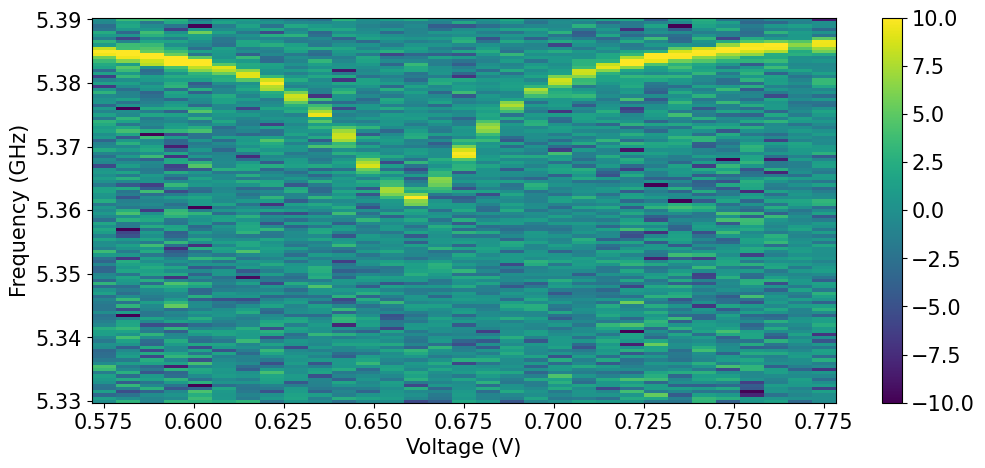

In [169]:
# plot transmission data

voltage_vector, frequencies, transmission_data = get_data(Q3_C34_filename_1)
frequency_step = frequencies[1] - frequencies[0]
voltage_step = voltage_vector[1] - voltage_vector[0]

plt.imshow(transmission_data, vmin=-10, vmax=10, aspect='auto', interpolation='None', origin='lower', extent=(voltage_vector[0] - voltage_step/2, voltage_vector[-1] + voltage_step/2, frequencies[0] - frequency_step/2, frequencies[-1] + frequency_step/2))
# plt.plot(indices_with_fit + 0.5, center_frequencies, marker='o', linestyle='', color='red')

plt.colorbar()
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')

plt.show()

### 1.3 Extract Frequencies

In [170]:
# label data by a qubit coupler tuple e.g. ('Q2', 'C12')

qubit_coupler_to_voltages = {}
qubit_coupler_to_frequencies = {}

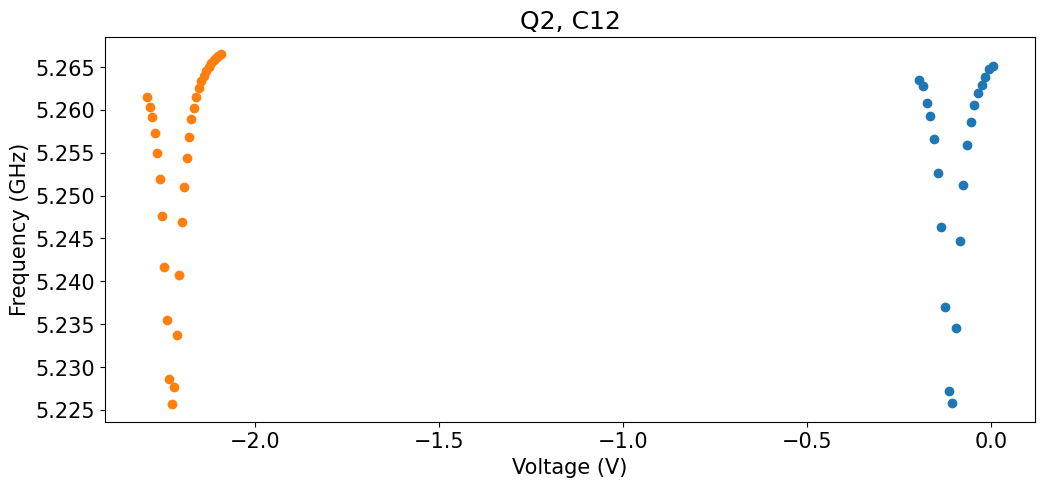

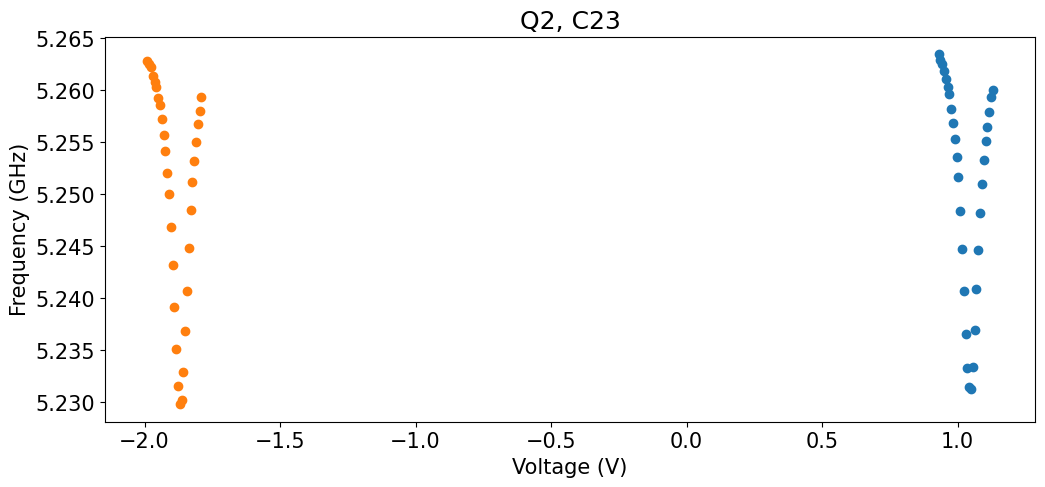

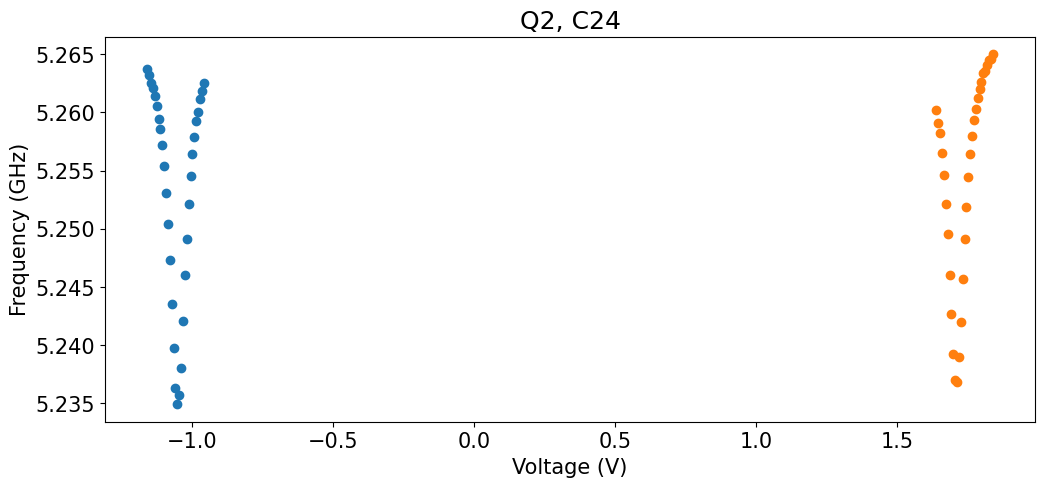

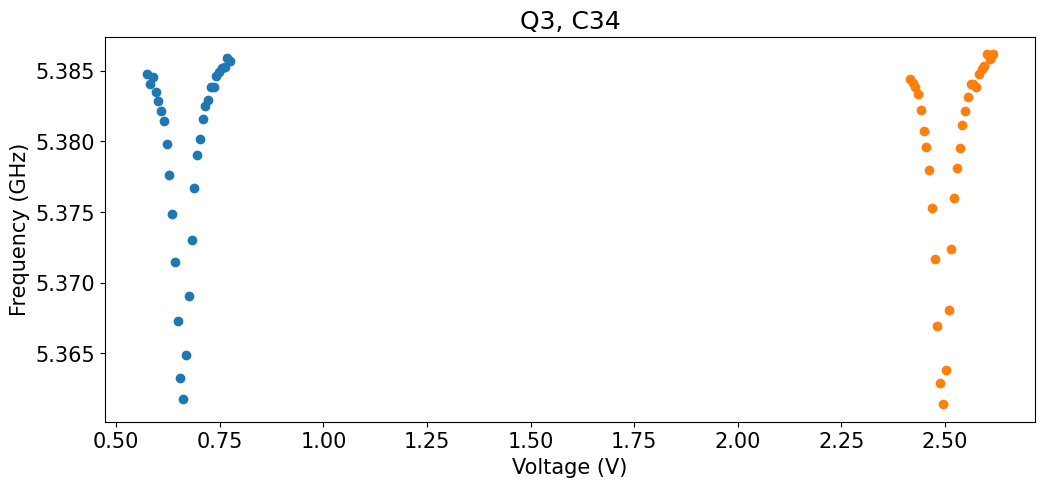

In [171]:
# Fit coupler peaks

extract_qubit_couplers = [('Q2', 'C12'), ('Q2', 'C23'), ('Q2', 'C24'), ('Q3', 'C34')]

for qubit, coupler in extract_qubit_couplers:

    qubit_coupler_voltages = []
    qubit_coupler_frequencies = []

    plot_fits = False
    start_index = 5
    frequency_index_span = 50

    for file in qubit_coupler_to_filenames[(qubit, coupler)]:

        voltage_data, frequency_data, transmission_data = get_data(file)
        file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)
        plt.show()

        qubit_coupler_voltages.append(np.array(file_voltages))
        qubit_coupler_frequencies.append(np.array(file_frequencies))
        
        
    
    qubit_coupler_to_voltages[(qubit, coupler)] = qubit_coupler_voltages
    qubit_coupler_to_frequencies[(qubit, coupler)] = qubit_coupler_frequencies
    
    
    for i in range(len(qubit_coupler_voltages)):
        plt.plot(qubit_coupler_voltages[i], qubit_coupler_frequencies[i], marker='o', linestyle='')

    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(f'{qubit}, {coupler}')

    plt.show()



### 1.4 Fit Coupler Peak to Lorentzian

In [172]:
def fit_coupler_peak(voltages, frequencies, plot_fits=False):
    
    peak_index_guess = np.argmax(-frequencies)
    peak_voltage_guess = voltages[peak_index_guess]
    
    bounds = ([voltages[0], -np.inf, 0, -np.inf], [voltages[-1], np.inf, np.inf, np.inf])
    initial_guess = [peak_voltage_guess, -1e-5, 0.0001, 5.25]
    
    popt, pcov = curve_fit(lorentzian_fit, voltages, frequencies, p0=initial_guess, bounds=bounds)
    
    if plot_fits:
        plt.plot(voltages, frequencies, linestyle='', marker='o', label='data')
    #     plt.plot(voltages, lorentzian_fit(voltages, *initial_guess), label='guess')
    
        fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
        plt.plot(fit_voltages, lorentzian_fit(fit_voltages, *popt), label='fit')
        plt.xlabel('Frequency (MHz)')
        plt.title(f'Lorentzian fit for index {i}')
        plt.axvline(peak_voltage_guess, color='red', linestyle=':')
        plt.legend()
        plt.show()
        
    return popt
    


In [378]:
def fit_coupler_peak_n_lorentzian(voltages, frequencies, n=2, initial_guess=None, plot_fits=False):
    '''
    n > 2, if n = 1 then use the normal lorentzian fit function
    '''
    print(n)
    
    peak_index_guess = np.argmax(-frequencies)
    peak_voltage_guess = voltages[peak_index_guess]
    
    bounds = ([voltages[0], -np.inf, 0]*n + [-np.inf], [voltages[-1], np.inf, np.inf]*n + [np.inf])
    
    if initial_guess is None:
        initial_guess = []
        for i in range(n):
            initial_guess += [voltages[int(len(voltages)*(i+1)/(n+1))], -1e-5, 0.0001]
        initial_guess += [5.25]
    
    fit_function = lambda x, *args: n_lorentzian_fit(x, n, *args)
    
    popt, pcov = curve_fit(fit_function, voltages, frequencies, p0=initial_guess, bounds=bounds)
    
    if plot_fits:
        plt.plot(voltages, frequencies, linestyle='', marker='o', label='data')
        plt.plot(voltages, fit_function(voltages, *initial_guess), label='guess')
    
        fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
        plt.plot(fit_voltages, fit_function(fit_voltages, *popt), label='fit')
        plt.xlabel('Frequency (MHz)')
        plt.title(f'{n}-Lorentzian fit')
        plt.axvline(peak_voltage_guess, color='red', linestyle=':')
        plt.legend()
        plt.show()
        
    return popt
    


In [173]:
qubit_coupler_to_peak_voltages = {}
qubit_coupler_to_flux_quantum_voltage = {}

In [200]:
fit_qubit_coupler = [('Q2', 'C12'), ('Q2', 'C23'), ('Q2', 'C24'), ('Q3', 'C34')]

for qubit, coupler in fit_qubit_coupler:

    qubit_coupler_voltages = qubit_coupler_to_voltages[(qubit, coupler)]
    qubit_coupler_frequencies = qubit_coupler_to_frequencies[(qubit, coupler)]
    
    peak_voltages = []

    for i in range(len(qubit_coupler_voltages)):
        popt = fit_coupler_peak(qubit_coupler_voltages[i], qubit_coupler_frequencies[i])
        peak_voltages.append(popt[0])
        
    qubit_coupler_to_peak_voltages[(qubit, coupler)] = peak_voltages
    
    flux_quantum_voltage = peak_voltages[1] - peak_voltages[0]
    qubit_coupler_to_flux_quantum_voltage[(qubit, coupler)] = abs(flux_quantum_voltage)
    
    print(f'Flux Quantum: {round(abs(flux_quantum_voltage), 3)}')

Flux Quantum: 2.116
Flux Quantum: 2.915
Flux Quantum: 2.762
Flux Quantum: 1.834


# 2. Coupler Flux Inverses
Take one coupler flux peak, fit to Lorentzian, and get the inverse

### 2.1 Import Data

In [204]:
coupler_to_filenames = {}

coupler_to_filenames['C12'] = generate_filename('0725', '1705')

coupler_to_filenames['C34'] = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk analysis\measurements\C34\2Tone4Qubit_NR_20240729_0027'

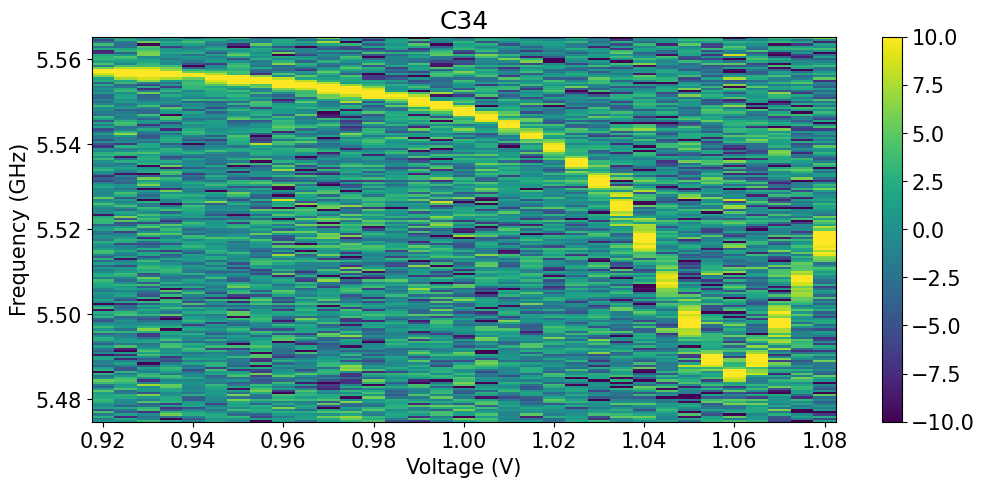

In [205]:
# plot transmission data

for coupler, filename in coupler_to_filenames.items():
    
    if not coupler == 'C34':
        continue

    voltage_vector, frequencies, transmission_data = get_data(filename)
    frequency_step = frequencies[1] - frequencies[0]
    voltage_step = voltage_vector[1] - voltage_vector[0]

    plt.imshow(transmission_data, vmin=-10, vmax=10, aspect='auto', interpolation='None', origin='lower', extent=(voltage_vector[0] - voltage_step/2, voltage_vector[-1] + voltage_step/2, frequencies[0] - frequency_step/2, frequencies[-1] + frequency_step/2))
    # plt.plot(indices_with_fit + 0.5, center_frequencies, marker='o', linestyle='', color='red')

    plt.colorbar()
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(coupler)
    
    plt.show()

### 2.2 Extract Frequencies

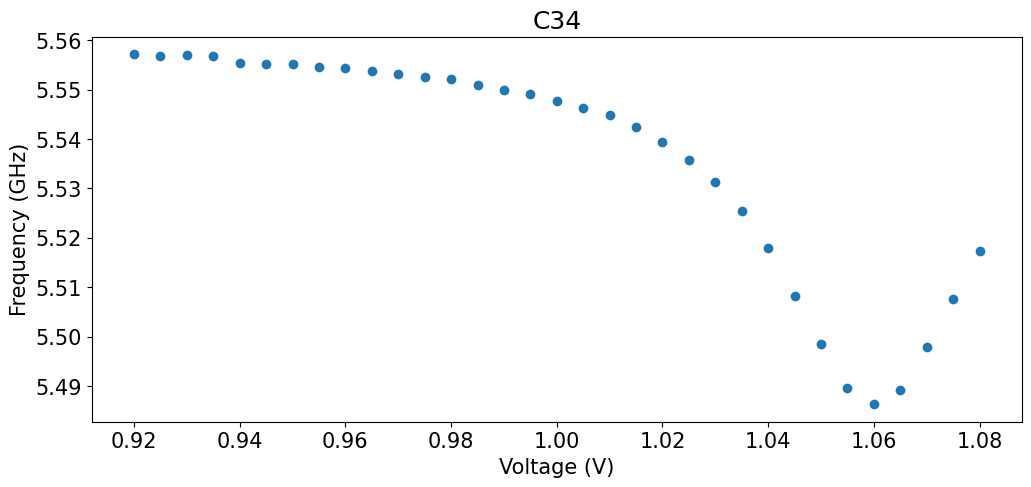

In [206]:
# label data by a coupler e.g. 'C12'

coupler_to_voltages = {}
coupler_to_frequencies = {}

# Fit coupler peaks

extract_couplers = ['C12']
extract_couplers = ['C34']

for coupler in extract_couplers:

    plot_fits = False
    start_index = 5
    frequency_index_span = 50

    filename = coupler_to_filenames[coupler]

    voltage_data, frequency_data, transmission_data = get_data(filename)
    file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)
    plt.show()

    
    coupler_to_voltages[coupler] = np.array(file_voltages)
    coupler_to_frequencies[coupler] = np.array(file_frequencies)
    
    
    plt.plot(coupler_to_voltages[coupler], coupler_to_frequencies[coupler], marker='o', linestyle='')

    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(f'{coupler}')

    plt.show()



### 2.3 Fit Coupler peak to Lorentzian

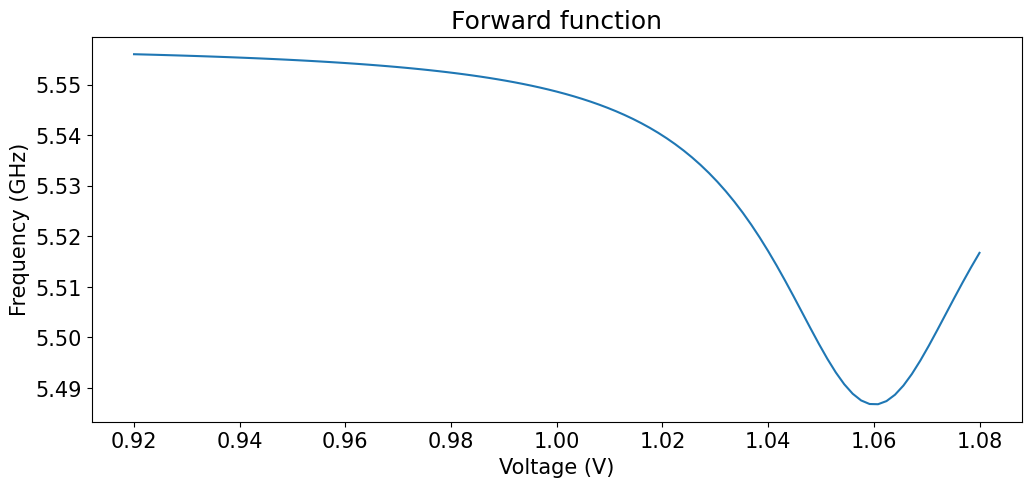

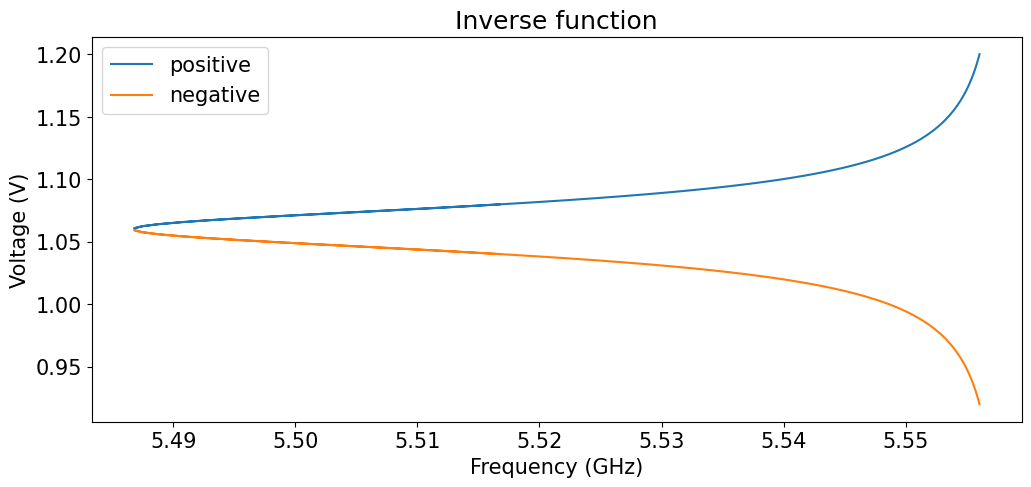

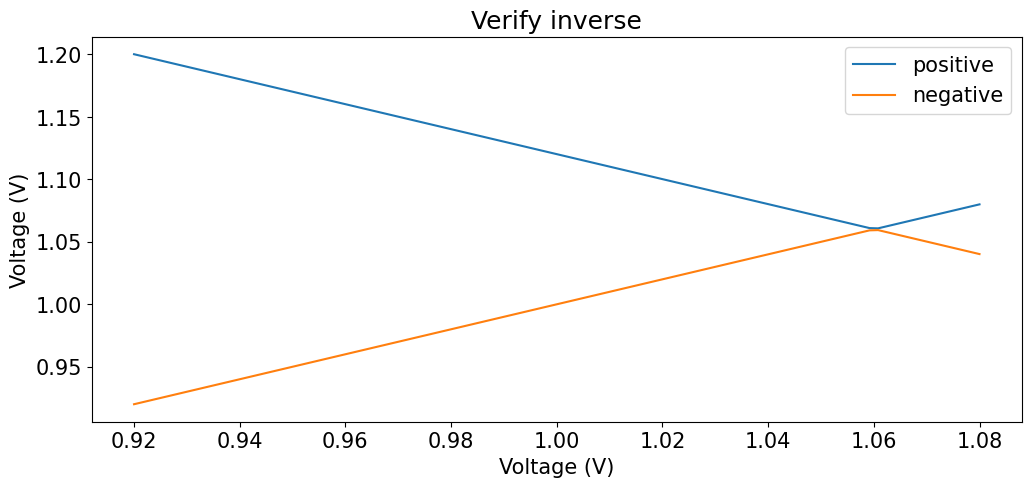

In [207]:
# label data by a coupler e.g. 'C12'

coupler_to_function = {}
coupler_to_inverse_function = {}
coupler_to_peak_voltage = {}

# Fit coupler peaks

fit_couplers = ['C12']
fit_couplers = ['C34']

for coupler in fit_couplers:

    coupler_voltages = coupler_to_voltages[coupler]
    coupler_frequencies = coupler_to_frequencies[coupler]
    

    popt = fit_coupler_peak(coupler_voltages, coupler_frequencies)
    
    def create_coupler_function(popt):
        return lambda x: lorentzian_fit(x, *popt)
    
    def create_coupler_inverse_function(popt, positive=True):
        return lambda x: lorentzian_inverse(x, *popt, positive=positive)
    
    
    # forward function
    coupler_to_function[coupler] = create_coupler_function(popt)
    
        
    fit_voltages = np.linspace(coupler_voltages[0], coupler_voltages[-1], 101)
    fit_frequencies = coupler_to_function[coupler](fit_voltages)
    
    coupler_to_peak_voltage[coupler] = popt[0]
    
    plt.plot(fit_voltages, fit_frequencies)
    
    plt.title('Forward function')
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')
    plt.show()
    
    # inverse function
    # two functions depending on sign of square root
    
    coupler_to_inverse_function[coupler] = {}
    
    coupler_to_inverse_function[coupler]['positive'] = create_coupler_inverse_function(popt, True)
    coupler_to_inverse_function[coupler]['negative'] = create_coupler_inverse_function(popt, False)
    
    plt.plot(fit_frequencies, coupler_to_inverse_function[coupler]['positive'](fit_frequencies), label='positive')
    plt.plot(fit_frequencies, coupler_to_inverse_function[coupler]['negative'](fit_frequencies), label='negative')

    
    plt.title('Inverse function')
    plt.legend()
    
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Voltage (V)')
    plt.show()
    
    plt.plot(fit_voltages, coupler_to_inverse_function[coupler]['positive'](fit_frequencies), label='positive')
    plt.plot(fit_voltages, coupler_to_inverse_function[coupler]['negative'](fit_frequencies), label='negative')
    
    plt.title('Verify inverse')
    plt.legend()
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Voltage (V)')
    plt.show()


### 2.4 Convert Frequencies to flux points

In [215]:
coupler = 'C12'
qubit = 'Q2'

coupler = 'C34'
qubit = 'Q4'

flux_quantum = qubit_coupler_to_flux_quantum_voltage[('Q3', coupler)]
v_peak = coupler_to_peak_voltage[coupler]

# random voltage frequencies
# frequencies = [5.251250258752515, 5.263973004107854, 5.263354000290353, 5.2382430555741, 5.241279692924363, 5.264448948047291, 5.2561331046675575, 5.2364113274476205, 5.263344309269967, 5.26440172794041, 5.263556085381567, 5.250761164606942, 5.235366839596972, 5.252244578809224, 5.25205841898109, 5.25195677764082, 5.265009707516823, 5.23276183902492, 5.2648681155561095, 5.26266207604015, 5.226040580968309, 5.246557146217608, 5.265091947189291, 5.233160418909756, 5.253262184246372, 5.264085237220427, 5.264155499606081, 5.2473995136530505, 5.248819489418266, 5.240874994785429, 5.261519500542061, 5.264145127208436, 5.248458537059516, 5.253002500975513, 5.263147152388522, 5.248910029743504, 5.250544704552397, 5.244001306375062, 5.25378379657797, 5.249209585442898]
frequencies = [5.552551262440003, 5.548717768587937, 5.506467704248982, 5.506118213400742, 5.542666325078796, 5.544439609826842, 5.535813991321213, 5.556394713247542, 5.54284176735289, 5.505572001443642, 5.52811733287565, 5.5461898015989215, 5.543595542291532, 5.522490330696975, 5.546062782697839, 5.552286575842738, 5.520194734320028, 5.53718742826574, 5.490224590431302, 5.547391277375983, 5.55330784064483, 5.495275173276291, 5.545193271943951, 5.5515726980030715, 5.532646057601479, 5.4892366490325495, 5.537897140628434, 5.546593481829321, 5.5366866410422, 5.498708423561637, 5.532887949107032, 5.497540295207995, 5.541795942076761, 5.539036819225876, 5.546752679200417, 5.556131101832476]
               
voltage_points_positive = coupler_to_inverse_function[coupler]['positive'](frequencies)
voltage_points_negative = coupler_to_inverse_function[coupler]['negative'](frequencies)

flux_points_positive = voltage_to_flux(voltage_points_positive, v_peak, flux_quantum)
flux_points_negative = voltage_to_flux(voltage_points_negative, v_peak, flux_quantum)

print(flux_points_positive)
print()
print(flux_points_negative)

flux_points_negative

[0.04435269 0.0329265  0.00787076 0.00777441 0.02431468 0.02626685
 0.01892763 0.08482252 0.02449368 0.00762403 0.01497216 0.02857586
 0.02529636 0.01276548 0.02839253 0.04321852 0.01196769 0.01981492
 0.00288581 0.03045963 0.04809762 0.00469294 0.027207   0.04050935
 0.0171228  0.00242575 0.02030366 0.02917742 0.01948288 0.00571548
 0.01725046 0.00537678 0.02346624 0.0211377  0.02942297 0.07832255]

[-0.04435269 -0.0329265  -0.00787076 -0.00777441 -0.02431468 -0.02626685
 -0.01892763 -0.08482252 -0.02449368 -0.00762403 -0.01497216 -0.02857586
 -0.02529636 -0.01276548 -0.02839253 -0.04321852 -0.01196769 -0.01981492
 -0.00288581 -0.03045963 -0.04809762 -0.00469294 -0.027207   -0.04050935
 -0.0171228  -0.00242575 -0.02030366 -0.02917742 -0.01948288 -0.00571548
 -0.01725046 -0.00537678 -0.02346624 -0.0211377  -0.02942297 -0.07832255]


array([-0.04435269, -0.0329265 , -0.00787076, -0.00777441, -0.02431468,
       -0.02626685, -0.01892763, -0.08482252, -0.02449368, -0.00762403,
       -0.01497216, -0.02857586, -0.02529636, -0.01276548, -0.02839253,
       -0.04321852, -0.01196769, -0.01981492, -0.00288581, -0.03045963,
       -0.04809762, -0.00469294, -0.027207  , -0.04050935, -0.0171228 ,
       -0.00242575, -0.02030366, -0.02917742, -0.01948288, -0.00571548,
       -0.01725046, -0.00537678, -0.02346624, -0.0211377 , -0.02942297,
       -0.07832255])

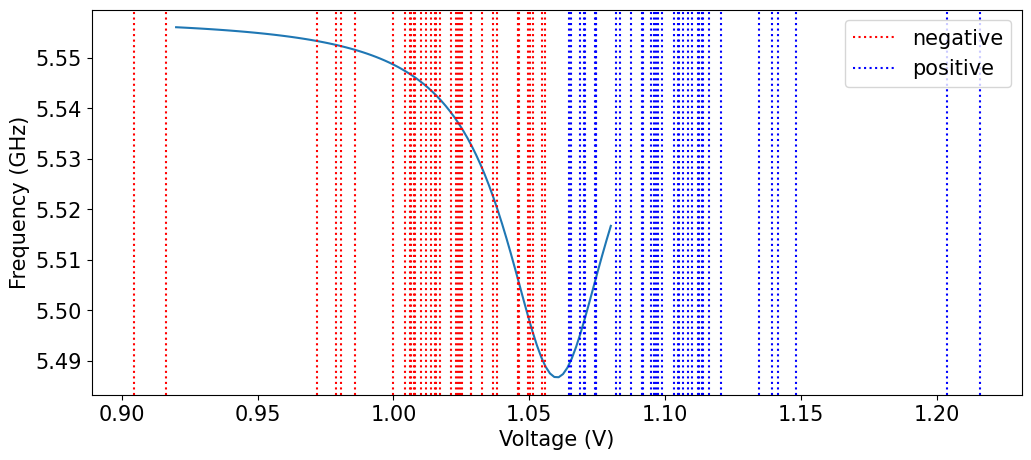

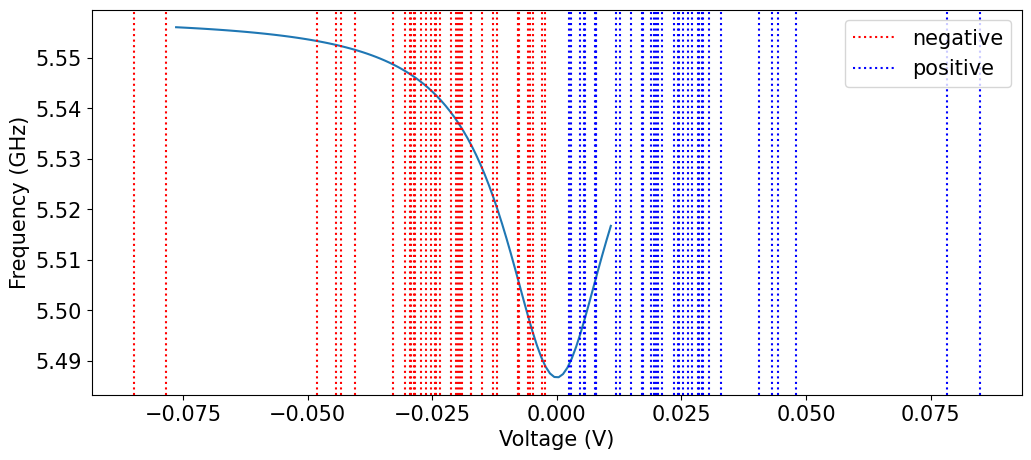

In [216]:
voltages = coupler_to_voltages[coupler]
fit_voltages = np.linspace(voltages[0], voltages[-1], 101)
coupler_function = coupler_to_function[coupler]


plt.plot(fit_voltages, coupler_function(fit_voltages))

for i in range(len(voltage_points_negative)):
    voltage = voltage_points_negative[i]
    if i == 0:
        plt.axvline(voltage, color='red', linestyle='dotted', label='negative')
    else:
        plt.axvline(voltage, color='red', linestyle='dotted')
        
for i in range(len(voltage_points_positive)):
    voltage = voltage_points_positive[i]
    if i == 0:
        plt.axvline(voltage, color='blue', linestyle='dotted', label='positive')
    else:
        plt.axvline(voltage, color='blue', linestyle='dotted')
    
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')
plt.legend()
plt.show()


# plot vs flux

flux_points = voltage_to_flux(fit_voltages, v_peak, flux_quantum)
plt.plot(flux_points, coupler_function(fit_voltages))

for i in range(len(flux_points_negative)):
    flux_point = flux_points_negative[i]
    if i == 0:
        plt.axvline(flux_point, color='red', linestyle='dotted', label='negative')
    else:
        plt.axvline(flux_point, color='red', linestyle='dotted')
        
for i in range(len(flux_points_positive)):
    flux_point = flux_points_positive[i]
    if i == 0:
        plt.axvline(flux_point, color='blue', linestyle='dotted', label='positive')
    else:
        plt.axvline(flux_point, color='blue', linestyle='dotted')
    
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')
plt.legend()
plt.show()


In [219]:
# this is the C34 fit voltage set converted to flux using the updated crosstalk matrix (4) after the fit
# I want to check what the frequencies of these new flux points using the updated crosstalk matrix are and compare that to the
# original random voltages frequency set we took to do the fit
C34_fit_flux_set_new = np.array([[-3.49177774e-01,  5.95437646e-01, -2.77555756e-17,
        -4.90867745e-01, -3.75887611e-01, -3.08288737e-01,
         1.31604907e+00, -4.85104488e-02],
       [-5.17398998e-01,  5.58018238e-01, -2.77555756e-17,
         1.46445531e+00,  3.03744286e-01, -4.97464855e-01,
         1.30654354e+00, -3.89557350e-02],
       [-7.06596366e-01,  3.73778580e-01,  0.00000000e+00,
         4.21161640e-01,  3.94358787e-01, -5.54942116e-01,
         5.10294746e-01, -1.15710794e-02],
       [-2.87796165e-01, -4.76993022e-01, -1.11022302e-16,
        -5.99367930e-01,  1.44076718e+00, -6.46552869e-01,
        -4.77145367e-01,  1.14970685e-03],
       [-4.28123487e-01,  5.43709000e-01,  5.55111512e-17,
         3.23128619e-01,  5.71770741e-01, -6.50106323e-01,
         3.37663525e-01, -2.50816821e-02],
       [-4.24485192e-01,  3.06847006e-01,  2.77555756e-17,
         3.86666862e-01,  4.55697367e-01, -4.56182606e-01,
         6.77948997e-01, -2.61996315e-02],
       [-5.49095757e-01,  3.27155802e-01, -5.55111512e-17,
         3.69560285e-01,  5.20431955e-01, -6.39338679e-01,
         6.52395338e-01, -2.14370346e-02],
       [ 3.18633297e-01,  5.01286497e-01, -1.11022302e-16,
        -4.31745992e-01,  4.58088235e-01, -4.04114772e-01,
         5.84285159e-01, -7.13009415e-02],
       [-4.68998063e-01,  5.53666721e-01,  0.00000000e+00,
         5.86211081e-01,  4.06635200e-01, -4.95396598e-01,
         5.07763374e-01, -2.66648401e-02],
       [-5.14185056e-01, -3.67112417e-01, -2.77555756e-17,
        -1.63525156e+00,  4.58612202e-01, -4.58965646e-01,
         3.56623435e-01,  9.37077467e-04],
       [-4.52182107e-01,  3.43310737e-01,  0.00000000e+00,
        -4.40363271e-01,  4.86523144e-01, -6.35000843e-01,
         4.13493273e-01, -1.52917316e-02],
       [-3.96839264e-01,  2.81821391e-01,  0.00000000e+00,
         3.06456155e-01,  4.69811991e-01, -4.34087867e-01,
         6.66397815e-01, -2.49221134e-02],
       [ 3.11716140e-01, -4.47199557e-01, -1.11022302e-16,
        -4.35623704e-01,  1.60450906e+00, -3.68347340e-01,
        -5.60370534e-01, -2.90516943e-02],
       [-5.56501862e-01,  3.87207517e-01, -2.77555756e-17,
        -4.27331989e-01,  3.15995767e-01, -5.64273282e-01,
         3.10858334e-01, -1.55584174e-02],
       [-3.20895890e-01,  3.88916794e-01, -2.77555756e-17,
         4.50973059e-01,  6.27140457e-01, -5.93917155e-01,
         6.45779783e-01, -3.09256491e-02],
       [ 4.26134920e-01,  2.87834726e-01, -5.55111512e-17,
        -3.80607718e-01,  1.31255645e+00, -5.18107836e-01,
        -6.47648351e-01, -4.92771211e-02],
       [-5.58766160e-01,  2.80786019e-01,  2.77555756e-17,
        -4.74013530e-01,  3.44739831e-01, -5.79586980e-01,
         4.84247941e-01, -1.37458457e-02],
       [-5.32727704e-01,  3.58009365e-01, -2.77555756e-17,
         3.09761446e-01,  4.62491128e-01, -4.47157237e-01,
         3.76502750e-01, -1.47476643e-02],
       [-4.18962973e-01, -4.36747154e-01, -5.55111512e-17,
        -1.49365436e+00,  6.19342120e-01, -5.20609442e-01,
         3.61204048e-01, -7.06359838e-03],
       [ 3.27763841e-01, -3.18229246e-01, -5.55111512e-17,
        -1.32347993e+00,  1.33035494e+00, -4.34651510e-01,
        -5.66696712e-01, -3.10907417e-02],
       [ 4.29590425e-01, -4.90688777e-01,  0.00000000e+00,
        -5.85676108e-01,  6.51711780e-01,  3.64549206e-01,
         3.28785547e-01, -4.91300803e-02],
       [-4.62484174e-01, -4.29868178e-01,  0.00000000e+00,
        -1.54956650e+00,  6.34834662e-01, -6.31422521e-01,
         4.47009293e-01, -6.55164796e-03],
       [-5.81994715e-01,  5.50292410e-01,  2.77555756e-17,
         3.55002955e-01,  3.02454779e-01, -5.58733034e-01,
         5.67652313e-01, -2.22188603e-02],
       [-3.48849270e-01,  7.13091577e-01, -1.11022302e-16,
         1.64961892e+00,  6.39573701e-01, -5.36930600e-01,
         6.72922922e-01, -3.96142822e-02],
       [-5.02824695e-01,  4.21775993e-01, -1.11022302e-16,
         5.57201299e-01,  5.52325745e-01, -5.67489485e-01,
         4.57237488e-01, -2.20930528e-02],
       [-5.04618767e-01, -3.62808850e-01,  5.55111512e-17,
        -1.31979574e+00,  4.53421094e-01, -5.05824706e-01,
         6.54654773e-01, -7.12618287e-03],
       [-3.18489351e-01,  3.88250279e-01,  0.00000000e+00,
        -4.34433120e-01,  5.41065465e-01, -6.08148746e-01,
         3.48834171e-01, -2.14707249e-02],
       [ 3.27207276e-01, -3.72342361e-01, -2.77555756e-17,
        -6.91306445e-01,  1.63920829e+00, -5.62412075e-01,
        -5.01746604e-01, -3.15980709e-02],
       [-3.14030655e-01,  3.24083713e-01, -8.32667268e-17,
        -6.84637992e-01,  4.00839944e-01, -5.62720542e-01,
         4.76922336e-01, -2.51021634e-02],
       [-3.54929893e-01, -3.06115644e-01, -5.55111512e-17,
        -1.51655384e+00,  3.77090458e-01, -3.39804898e-01,
         4.51519323e-01, -1.24383076e-02],
       [-7.00475470e-01,  4.80127474e-01, -8.32667268e-17,
         4.10708618e-01,  4.65504903e-01, -6.46677118e-01,
         3.71204060e-01, -1.05595411e-02],
       [-6.77215751e-01, -3.67826871e-01, -8.32667268e-17,
        -6.33048348e-01,  4.76514977e-01, -3.92785032e-01,
         6.83871790e-01,  4.58228866e-03],
       [-3.97447660e-01,  3.78255595e-01,  0.00000000e+00,
         4.75756009e-01,  6.97283905e-01, -6.23452472e-01,
         5.00056386e-01, -2.26862822e-02],
       [-5.32655387e-01,  4.53178296e-01, -2.77555756e-17,
         6.14540398e-01,  5.34746873e-01, -5.35010597e-01,
         3.48306353e-01, -2.03582585e-02],
       [-3.31860301e-01,  6.61372382e-01, -5.55111512e-17,
         4.27371626e-01,  5.04597474e-01, -5.54963208e-01,
         3.86190646e-01, -2.94082032e-02],
       [ 3.33709967e-01,  4.93230125e-01,  0.00000000e+00,
        -4.14657440e-01,  5.25478782e-01, -4.76998378e-01,
         6.37363216e-01, -7.23523949e-02]])

print(np.round(C34_fit_flux_set_new, 2))

[[-0.35  0.6  -0.   -0.49 -0.38 -0.31  1.32 -0.05]
 [-0.52  0.56 -0.    1.46  0.3  -0.5   1.31 -0.04]
 [-0.71  0.37  0.    0.42  0.39 -0.55  0.51 -0.01]
 [-0.29 -0.48 -0.   -0.6   1.44 -0.65 -0.48  0.  ]
 [-0.43  0.54  0.    0.32  0.57 -0.65  0.34 -0.03]
 [-0.42  0.31  0.    0.39  0.46 -0.46  0.68 -0.03]
 [-0.55  0.33 -0.    0.37  0.52 -0.64  0.65 -0.02]
 [ 0.32  0.5  -0.   -0.43  0.46 -0.4   0.58 -0.07]
 [-0.47  0.55  0.    0.59  0.41 -0.5   0.51 -0.03]
 [-0.51 -0.37 -0.   -1.64  0.46 -0.46  0.36  0.  ]
 [-0.45  0.34  0.   -0.44  0.49 -0.64  0.41 -0.02]
 [-0.4   0.28  0.    0.31  0.47 -0.43  0.67 -0.02]
 [ 0.31 -0.45 -0.   -0.44  1.6  -0.37 -0.56 -0.03]
 [-0.56  0.39 -0.   -0.43  0.32 -0.56  0.31 -0.02]
 [-0.32  0.39 -0.    0.45  0.63 -0.59  0.65 -0.03]
 [ 0.43  0.29 -0.   -0.38  1.31 -0.52 -0.65 -0.05]
 [-0.56  0.28  0.   -0.47  0.34 -0.58  0.48 -0.01]
 [-0.53  0.36 -0.    0.31  0.46 -0.45  0.38 -0.01]
 [-0.42 -0.44 -0.   -1.49  0.62 -0.52  0.36 -0.01]
 [ 0.33 -0.32 -0.   -1.32  1.33

In [220]:
# just the C34 column of the fluxes
C34_fit_flux_set_new_C34 = C34_fit_flux_set_new[:,7]

print(np.round(C34_fit_flux_set_new_C34, 2))

[-0.05 -0.04 -0.01  0.   -0.03 -0.03 -0.02 -0.07 -0.03  0.   -0.02 -0.02
 -0.03 -0.02 -0.03 -0.05 -0.01 -0.01 -0.01 -0.03 -0.05 -0.01 -0.02 -0.04
 -0.02 -0.01 -0.02 -0.03 -0.03 -0.01 -0.01  0.   -0.02 -0.02 -0.03 -0.07]


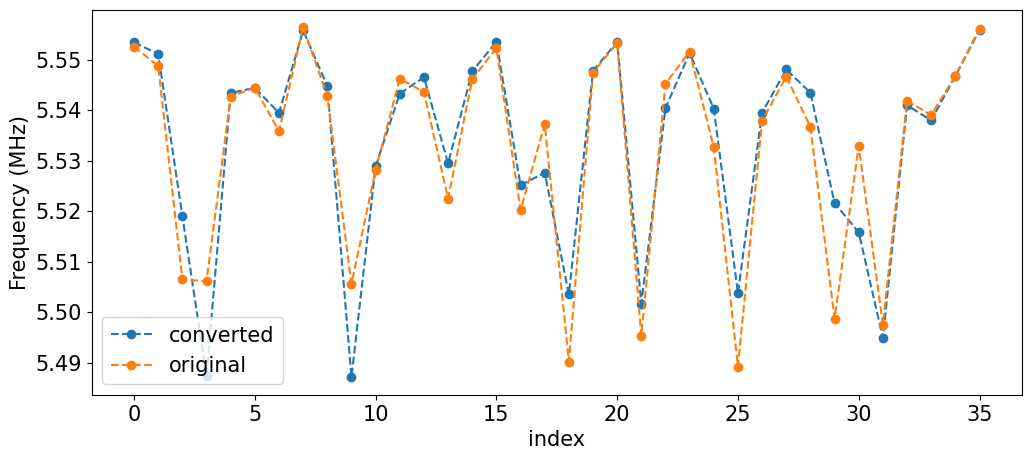

In [223]:

flux_quantum = qubit_coupler_to_flux_quantum_voltage[('Q3', 'C34')]
v_peak = coupler_to_peak_voltage['C34']

voltage_points = flux_to_voltage(C34_fit_flux_set_new_C34, v_peak, flux_quantum)

C34_fit_flux_set_frequency_points = coupler_to_function['C34'](voltage_points)

plt.plot(C34_fit_flux_set_frequency_points, label='converted', marker='o', linestyle='dashed')
plt.plot(frequencies, label='original', marker='o', linestyle='dashed')

plt.xlabel('index')
plt.ylabel('Frequency (GHz)')
plt.legend()

# 3. Multiple Couplers
In this section we're going to try to sweep multiple couplers simultaneously and see if the frequency shift is the same as the sum of both shifts individually

### 3.1 Sweep C12 and C23

In [225]:
C12_individual_filename = generate_filename('0731', '1315')
C13_individual_filename = generate_filename('0730', '0022')
C12_C23_simultaneous_filename = generate_filename('0730', '0108')

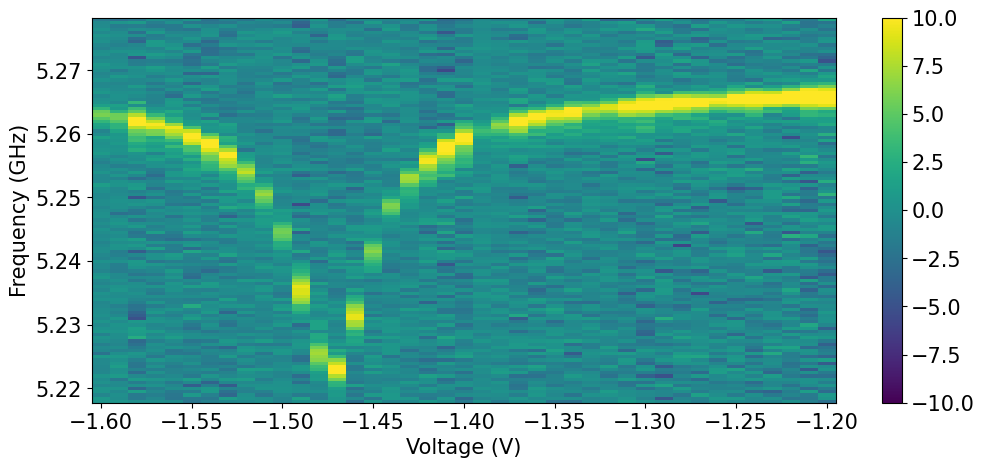

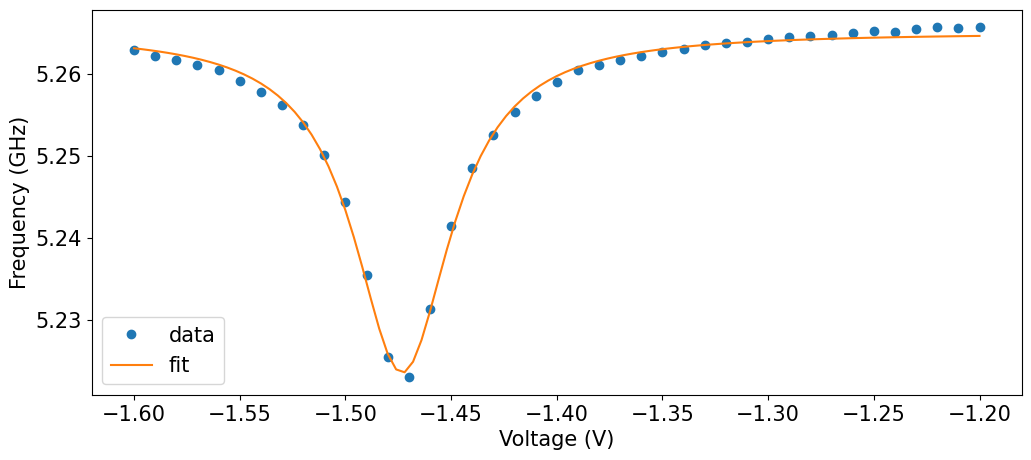

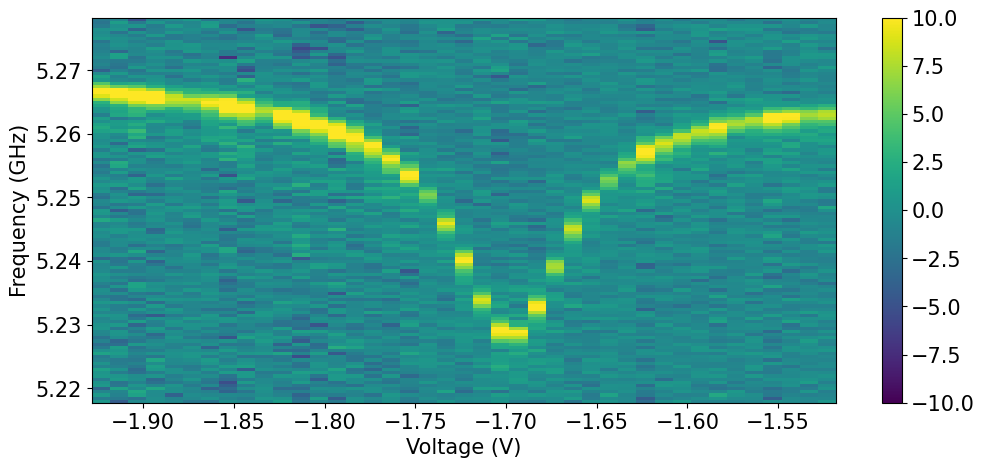

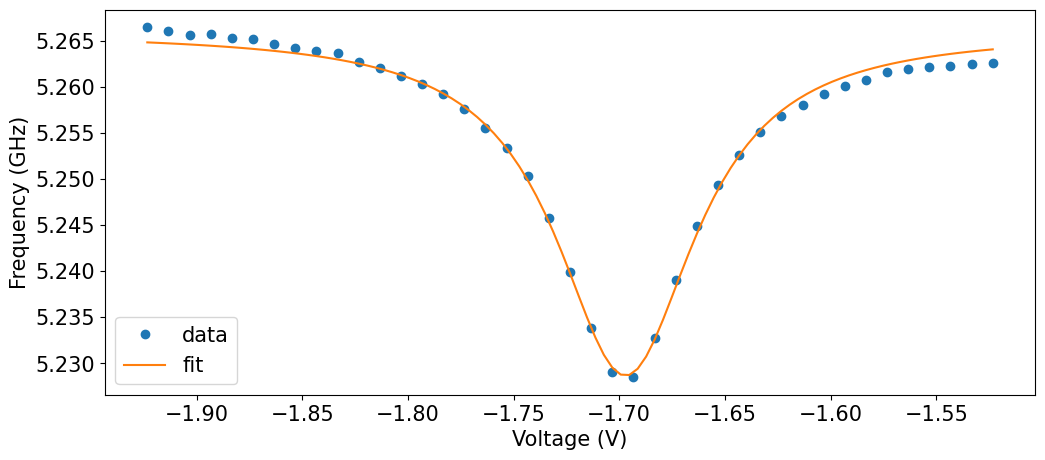

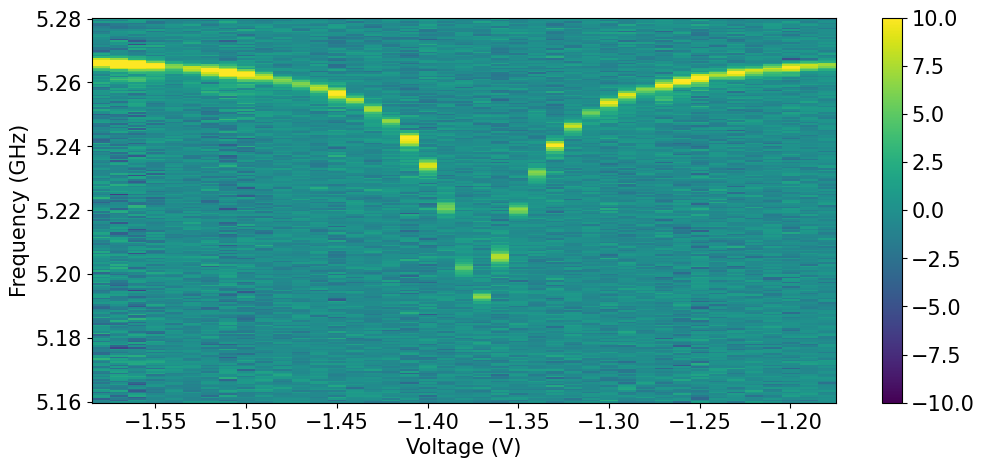

yes


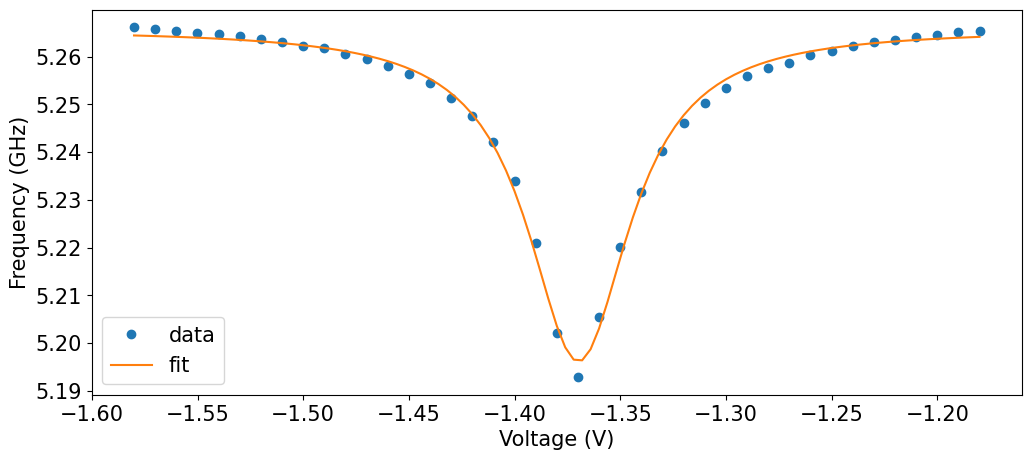

In [277]:
# plot transmission data

C12_flux_quantum = qubit_coupler_to_flux_quantum_voltage[('Q2', 'C12')]
C23_flux_quantum = qubit_coupler_to_flux_quantum_voltage[('Q2', 'C23')]

filenames = [C12_individual_filename, C13_individual_filename, C12_C23_simultaneous_filename]
for i in range(len(filenames)):
    
    filename = filenames[i]
    
    voltage_vector, frequencies, transmission_data = get_data(filename)
    frequency_step = frequencies[1] - frequencies[0]
    voltage_step = voltage_vector[1] - voltage_vector[0]

    plt.imshow(transmission_data, vmin=-10, vmax=10, aspect='auto', interpolation='None', origin='lower', extent=(voltage_vector[0] - voltage_step/2, voltage_vector[-1] + voltage_step/2, frequencies[0] - frequency_step/2, frequencies[-1] + frequency_step/2))
    # plt.plot(indices_with_fit + 0.5, center_frequencies, marker='o', linestyle='', color='red')

    plt.colorbar()
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

#     plt.title(coupler)

    plt.show()

    plot_fits = False
    start_index = 5
    frequency_index_span = 50


    voltage_data, frequency_data, transmission_data = get_data(filename)
    file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)
    plt.show()


    voltages = np.array(file_voltages)
    frequencies = np.array(file_frequencies)
    

    popt = fit_coupler_peak(voltages, frequencies)
    
    def create_coupler_function(popt):
        # in terms of flux
#         return lambda x: lorentzian_fit(x*_flux_quantum - popt[0], *popt)
        # in terms of voltage
        return lambda x: lorentzian_fit(x, *popt)
    
    def create_coupler_function_centered(popt):
        # in terms of flux
#         return lambda x: lorentzian_fit(x*_flux_quantum - popt[0], *popt)
        # in terms of voltage
        return lambda x: lorentzian_fit(x + popt[0], *popt)
    
    
    # forward function
    coupler_function = create_coupler_function(popt)
    
        
    
        
    
    if i == 0:
        C12_individual_voltages = voltages
        C12_individual_frequencies = frequencies
        C12_individual_coupler_function = coupler_function
        C12_individual_popt = popt
        C12_peak_voltage = popt[0]
    elif i == 1:
        C23_individual_voltages = voltages
        C23_individual_frequencies = frequencies
        C23_individual_coupler_function = coupler_function
        C23_individual_popt = popt
        C23_peak_voltage = popt[0]
    elif i == 2:
        print('yes')
        C12_C23_simultaneous_voltages = voltages
        C12_C23_simultaneous_frequencies = frequencies
        C12_C23_simultaneous_coupler_function = coupler_function
        C12_C23_simultaneous_popt = popt
        C12_C23_peak_voltage = popt[0]

    fit_voltages = np.linspace(voltages[0], voltages[-1], 101)
    fit_frequencies = coupler_function(fit_voltages)

    plt.plot(voltages, frequencies, marker='o', linestyle='', label='data')
    plt.plot(fit_voltages, fit_frequencies, label='fit')

    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')
    plt.legend()

    plt.show()

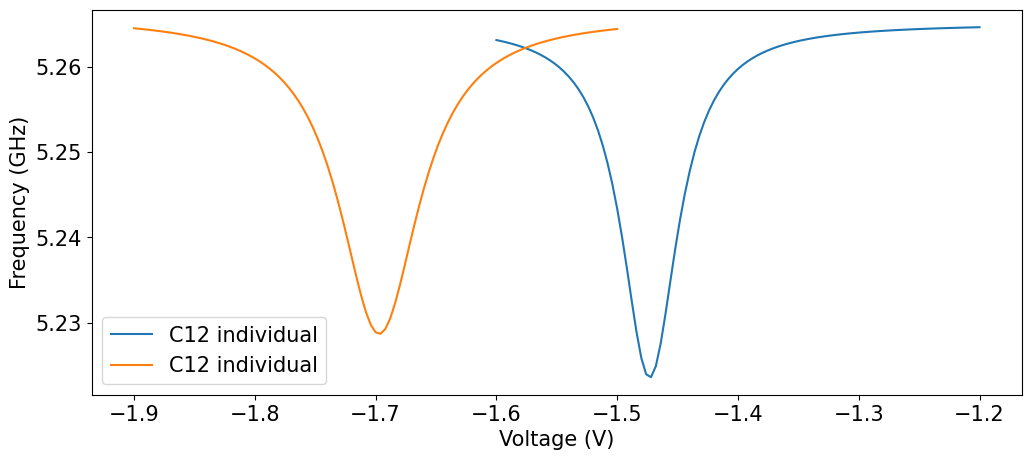

In [274]:
C12_fit_voltages = np.linspace(-1.6, -1.2, 101)
C23_fit_voltages = np.linspace(-1.9, -1.5, 101)

C12_fit_frequencies = C12_individual_coupler_function(C12_fit_voltages)
C23_fit_frequencies = C23_individual_coupler_function(C23_fit_voltages)

plt.plot(C12_fit_voltages, C12_fit_frequencies, label='C12 individual')
plt.plot(C23_fit_voltages, C23_fit_frequencies, label='C12 individual')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')
plt.legend()

plt.show()

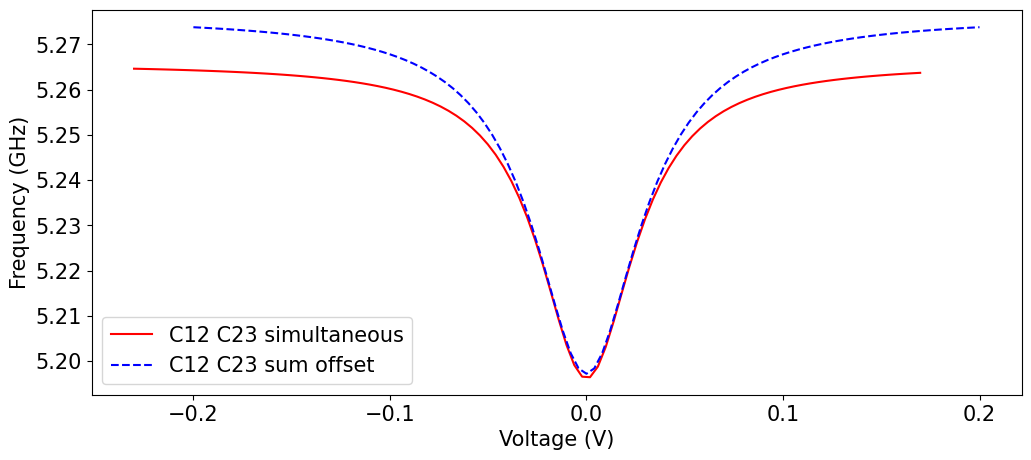

In [294]:
# now center them

C12_fit_voltages = np.linspace(-1.6, -1.2, 101)
C23_fit_voltages = np.linspace(-1.9, -1.5, 101)

C12_fit_frequencies = C12_individual_coupler_function(C12_fit_voltages)
C23_fit_frequencies = C23_individual_coupler_function(C23_fit_voltages)

# plt.plot(C12_fit_voltages - C12_peak_voltage, C12_fit_frequencies, color='magenta', linestyle='dotted', label='C12 individual centered')
# plt.plot(C23_fit_voltages - C23_peak_voltage, C23_fit_frequencies, color='purple', linestyle='dotted',  label='C23 individual centered')

plt.plot(C12_fit_voltages - C12_C23_peak_voltage, C12_C23_simultaneous_coupler_function(C12_fit_voltages), color='red', label='C12 C23 simultaneous')

C12_C23_sum_function = lambda x: lorentzian_fit(x + C12_individual_popt[0], *C12_individual_popt) + lorentzian_fit(x + C23_individual_popt[0], *C23_individual_popt)


offset = -5.255
sum_fit_voltages = np.linspace(-0.2, 0.2, 101)
sum_fit_frequencies = C12_C23_sum_function(sum_fit_voltages) + offset

plt.plot(sum_fit_voltages, sum_fit_frequencies, color='blue', linestyle='dashed', label='C12 C23 sum offset')

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')
plt.legend()

plt.show()

### 3.2 Sweep C12, C23, and C24

In [404]:
coupler_combinations = []

for length in [1, 2, 3]:
    for combination in combinations(['C12', 'C23', 'C24'], length):
        print(combination)
        coupler_combinations.append(combination)


('C12',)
('C23',)
('C24',)
('C12', 'C23')
('C12', 'C24')
('C23', 'C24')
('C12', 'C23', 'C24')


In [405]:
couplers_to_C12_C23_C34_filename = {}

couplers_to_C12_C23_C34_voltages = {coupler_combination: [] for coupler_combination in coupler_combinations}
couplers_to_C12_C23_C34_frequencies = {coupler_combination: [] for coupler_combination in coupler_combinations}

couplers_to_C12_C23_C34_function = {coupler_combination: [] for coupler_combination in coupler_combinations}
couplers_to_C12_C23_C34_popt = {coupler_combination: [] for coupler_combination in coupler_combinations}
couplers_to_C12_C23_C34_peak_voltage = {coupler_combination: [] for coupler_combination in coupler_combinations}


In [406]:

couplers_to_C12_C23_C34_filename[('C12',)] = generate_filename('0801', '1432')
couplers_to_C12_C23_C34_filename[('C23',)] = generate_filename('0801', '1525')
couplers_to_C12_C23_C34_filename[('C24',)] = generate_filename('0801', '1311')

couplers_to_C12_C23_C34_filename[('C12', 'C23')] = [generate_filename('0801', '1738'),
                                                    generate_filename('0802', '1040'),
                                                    generate_filename('0802', '1128')]
couplers_to_C12_C23_C34_filename[('C12', 'C24')] = generate_filename('0802', '1319')
couplers_to_C12_C23_C34_filename[('C23', 'C24')] = generate_filename('0802', '1359')

couplers_to_C12_C23_C34_filename[('C12', 'C23', 'C24')] = generate_filename('0802', '1212')



V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080124\2Tone4Qubit_NR_20240801_1432


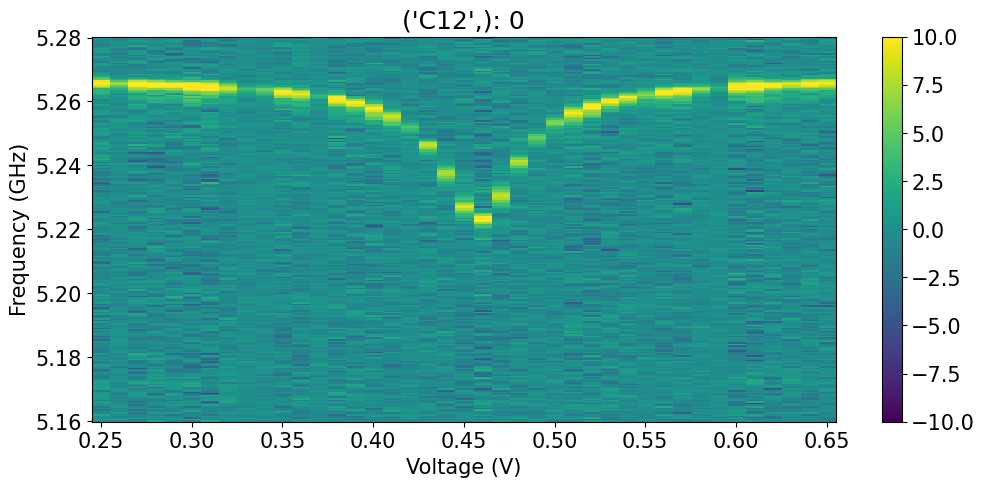

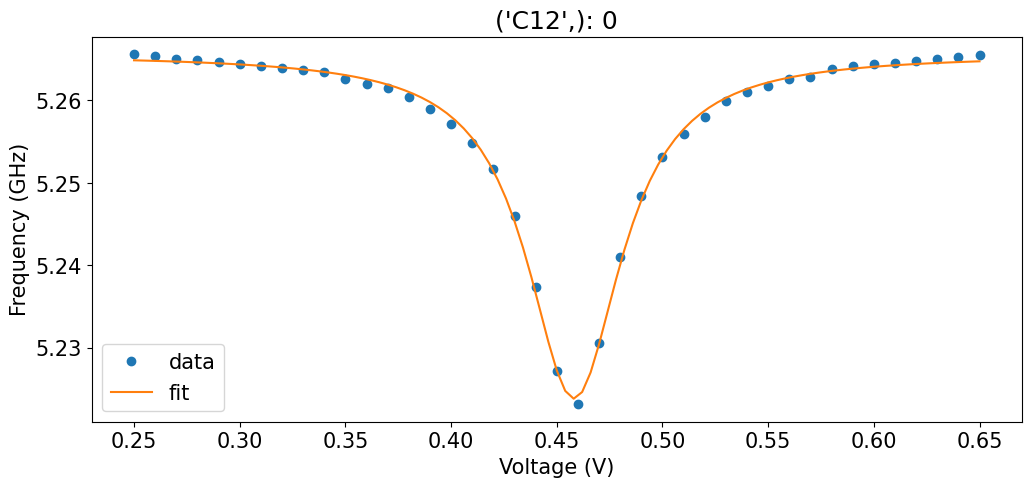

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080124\2Tone4Qubit_NR_20240801_1525


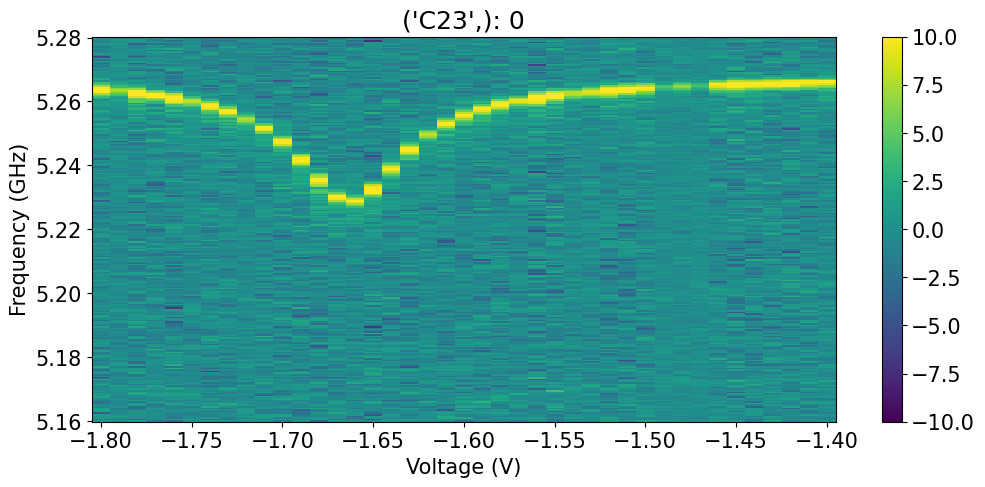

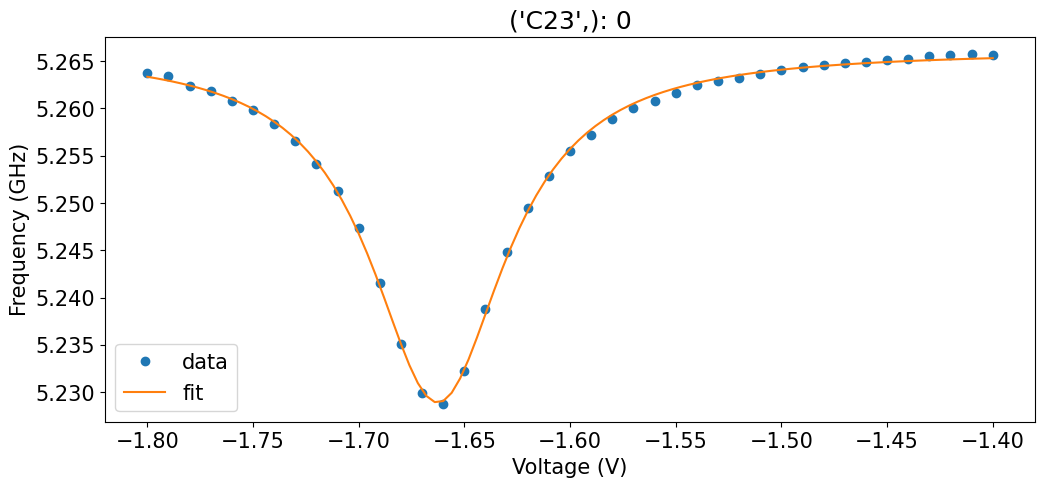

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080124\2Tone4Qubit_NR_20240801_1311


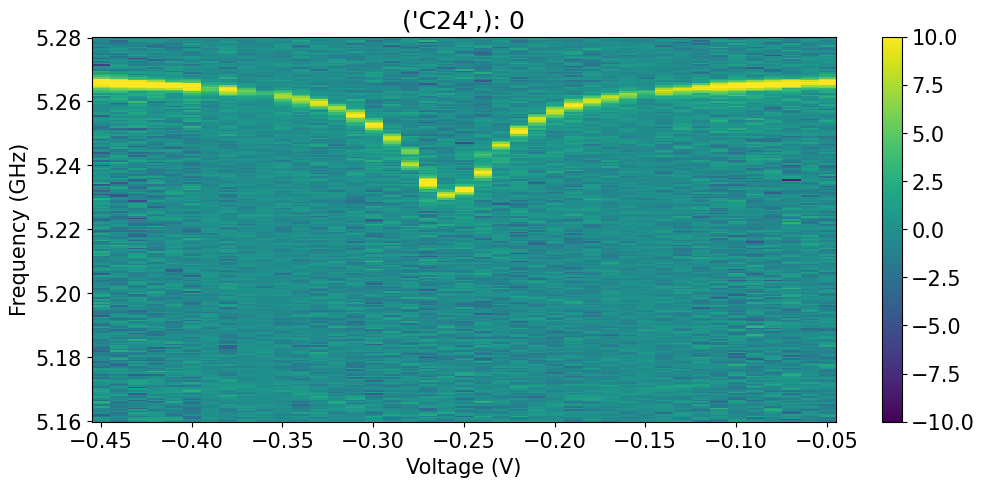

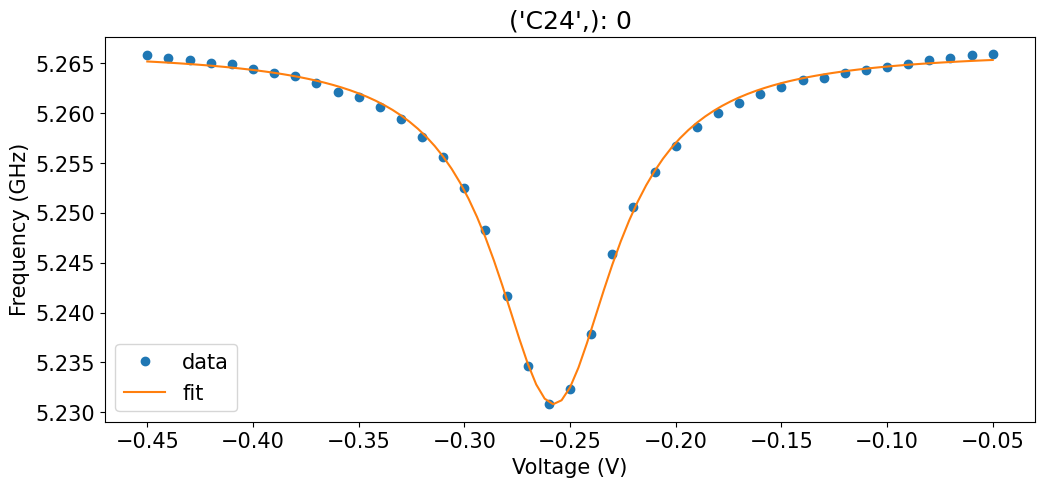

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080124\2Tone4Qubit_NR_20240801_1738


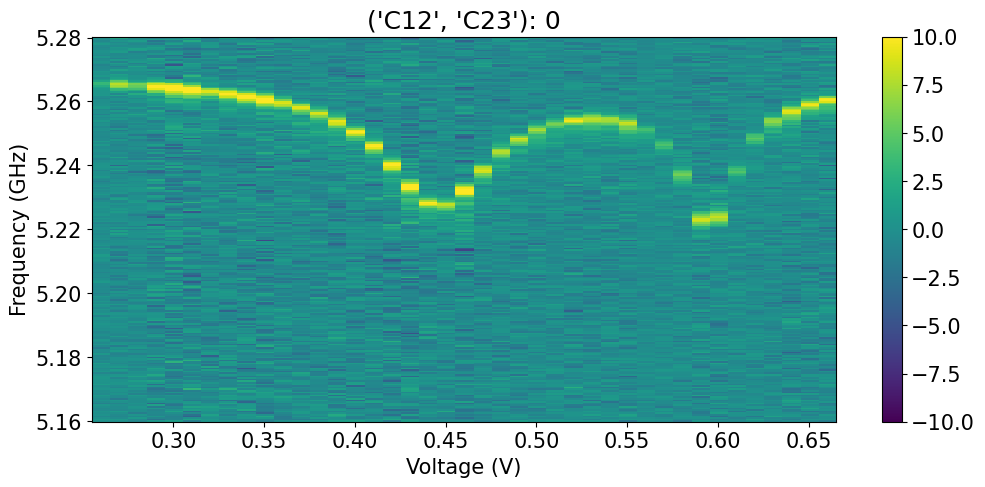

2


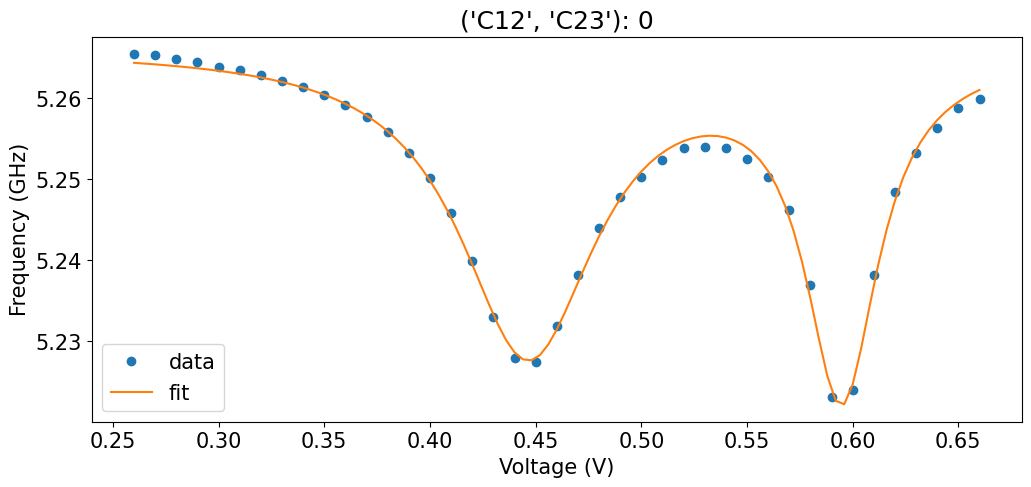

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080224\2Tone4Qubit_NR_20240802_1040


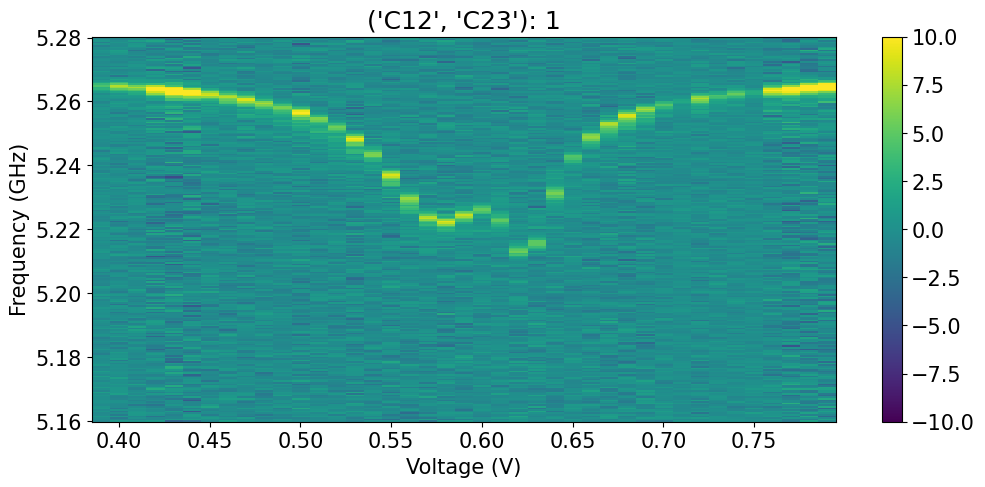

2


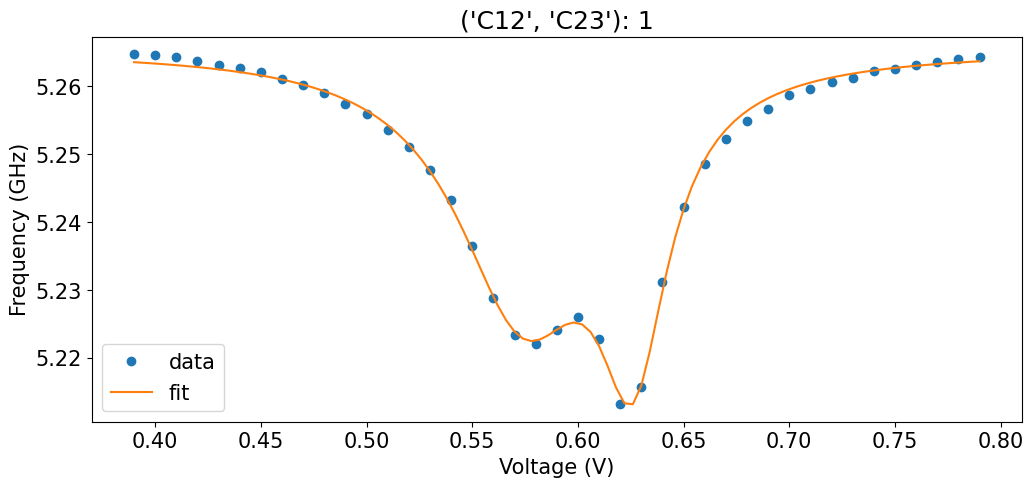

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080224\2Tone4Qubit_NR_20240802_1128


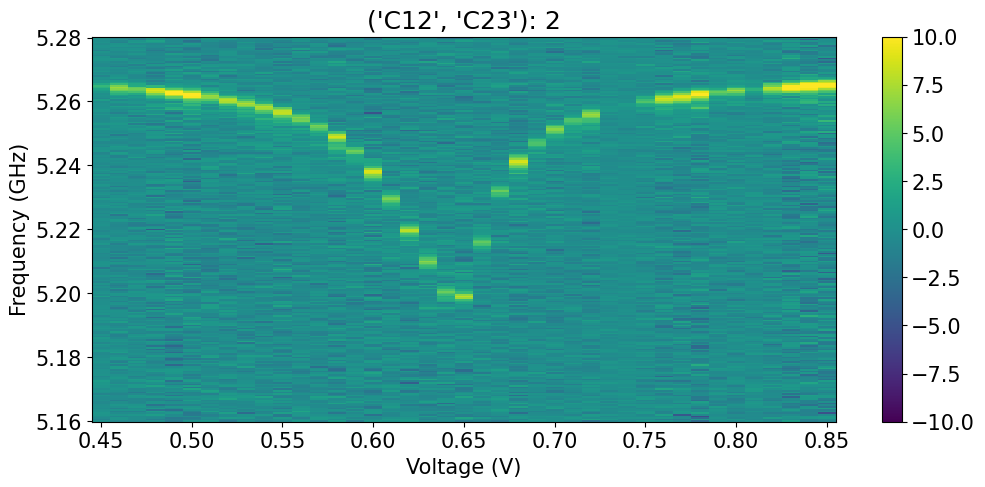

2


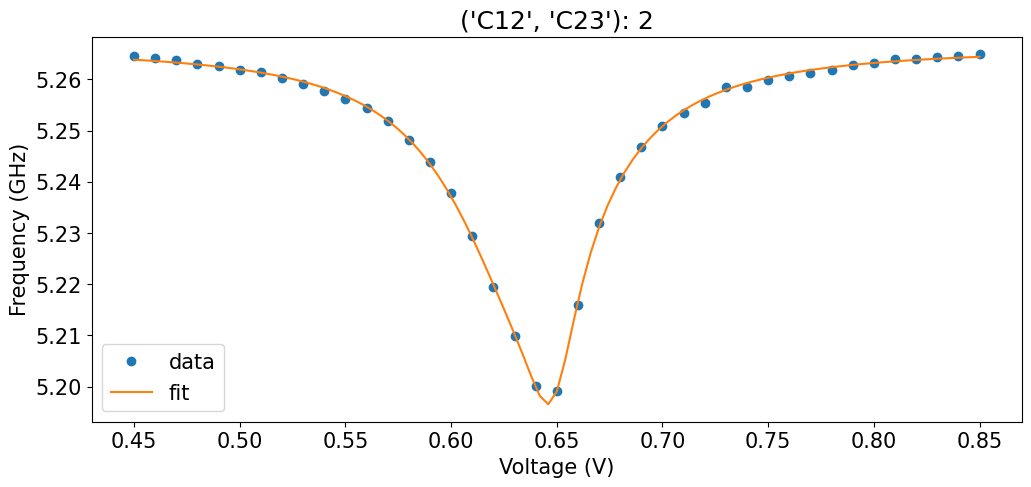

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080224\2Tone4Qubit_NR_20240802_1319


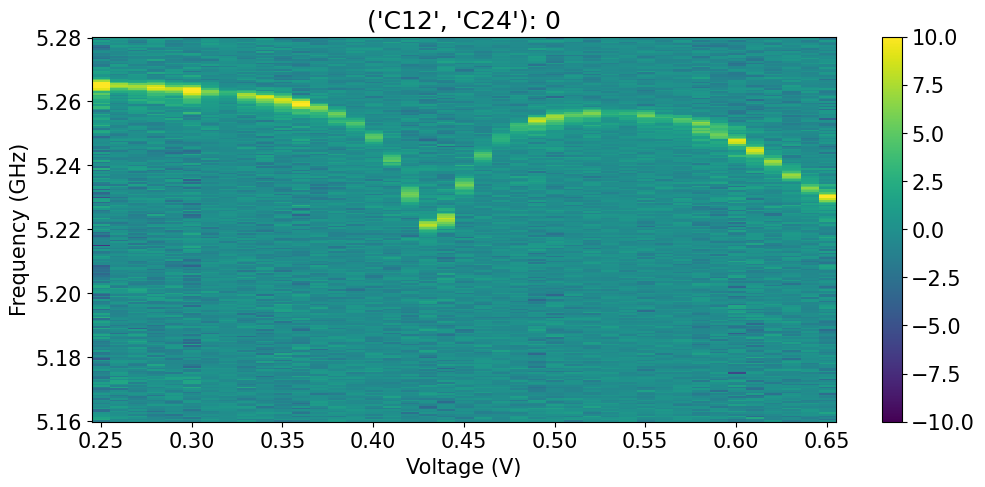

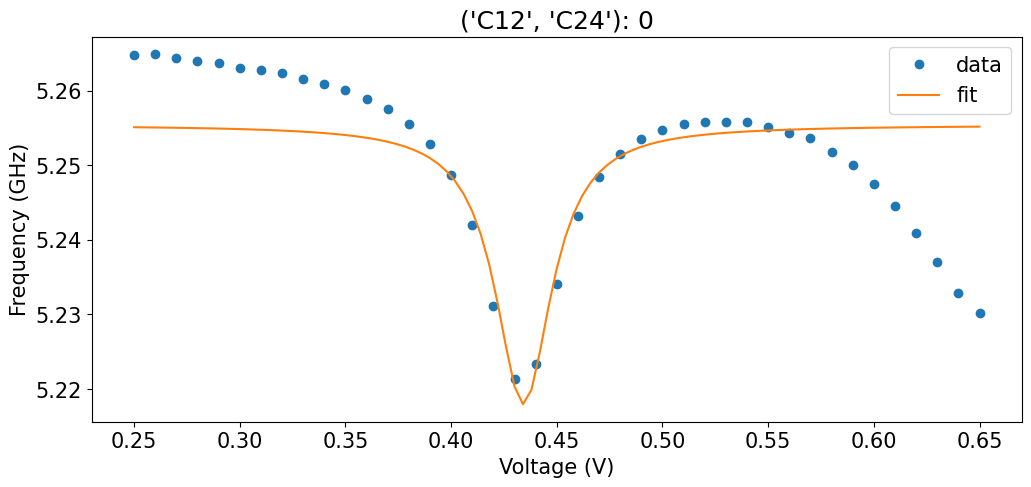

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080224\2Tone4Qubit_NR_20240802_1359


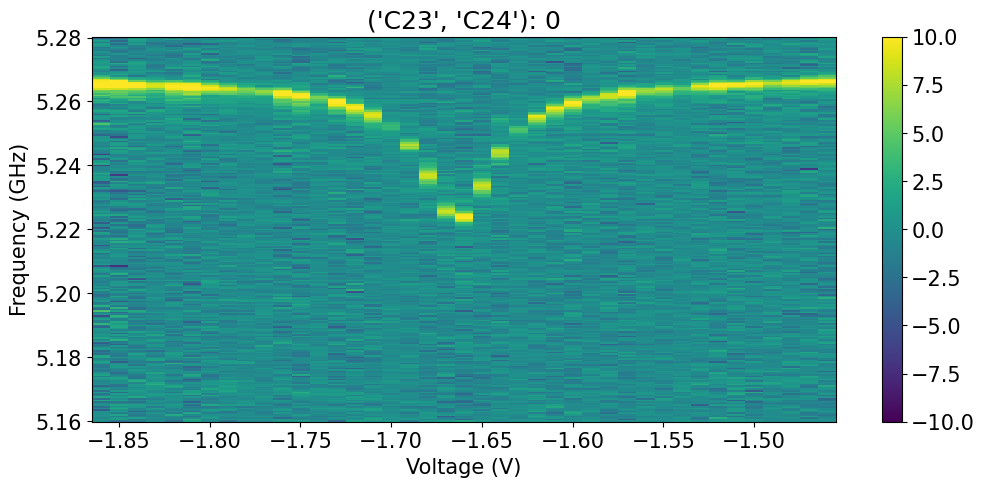

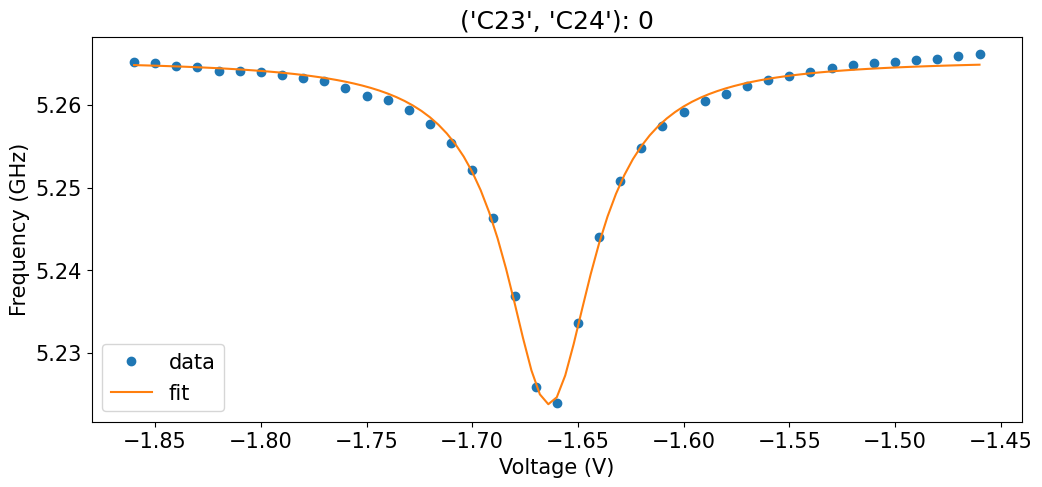

V:\QSimMeasurements\Measurements\4Q_Triangle_Lattice\pnax080224\2Tone4Qubit_NR_20240802_1212


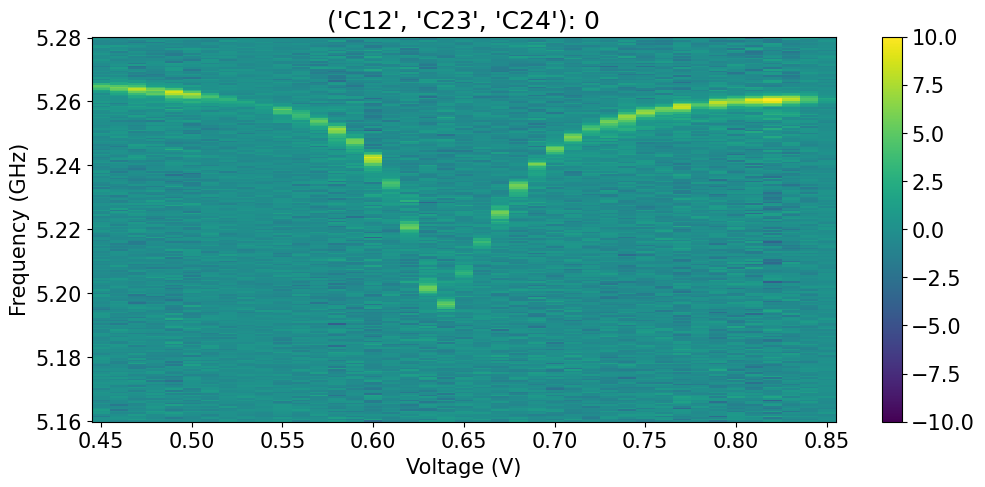

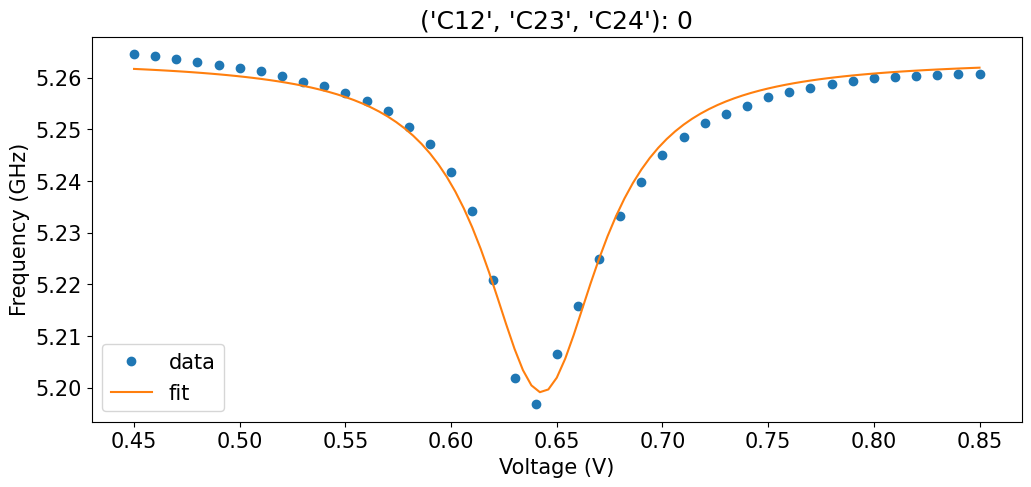

In [407]:
# plot transmission data

for coupler_combination in coupler_combinations:
# for coupler_combination in [('C12', 'C23')]:

    filenames = couplers_to_C12_C23_C34_filename[coupler_combination]
    
    couplers_to_C12_C23_C34_voltages[coupler_combination] = []
    couplers_to_C12_C23_C34_frequencies[coupler_combination] = []

    couplers_to_C12_C23_C34_function[coupler_combination] = []
    couplers_to_C12_C23_C34_popt[coupler_combination] = []
    couplers_to_C12_C23_C34_peak_voltage[coupler_combination] = []
    
    if not isinstance(filenames, list):
        filenames = [filenames]
    
        
    for i in range(len(filenames)):
        filename = filenames[i]
        
        print(filename)

        voltage_vector, frequencies, transmission_data = get_data(filename)
        frequency_step = frequencies[1] - frequencies[0]
        voltage_step = voltage_vector[1] - voltage_vector[0]

        plt.imshow(transmission_data, vmin=-10, vmax=10, aspect='auto', interpolation='None', origin='lower', extent=(voltage_vector[0] - voltage_step/2, voltage_vector[-1] + voltage_step/2, frequencies[0] - frequency_step/2, frequencies[-1] + frequency_step/2))
        # plt.plot(indices_with_fit + 0.5, center_frequencies, marker='o', linestyle='', color='red')

        plt.colorbar()
        plt.xlabel('Voltage (V)')
        plt.ylabel('Frequency (GHz)')
        plt.title(f'{coupler_combination}: {i}')

        plt.show()

        plot_fits = False
        start_index = 5
        frequency_index_span = 50


    #     voltage_data, frequency_data, transmission_data = get_data(filename)
        file_voltages, file_frequencies, error = get_center_frequencies(voltage_vector, frequencies, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)
        plt.show()


        voltages = np.array(file_voltages)
        frequencies = np.array(file_frequencies)
        
        def create_coupler_function(popt, n=None):
            # in terms of flux
    #         return lambda x: lorentzian_fit(x*_flux_quantum - popt[0], *popt)
            # in terms of voltage
            if n is None or n == 1:
                return lambda x: lorentzian_fit(x, *popt)
            else:
                return lambda x: n_lorentzian_fit(x, n, *popt)
                

        def create_coupler_function_centered(popt):
            # in terms of flux
    #         return lambda x: lorentzian_fit(x*_flux_quantum - popt[0], *popt)
            # in terms of voltage
            return lambda x: lorentzian_fit(x + popt[0], *popt)

        if coupler_combination == ('C12', 'C23'):
            if i == 0:
                initial_guess = [0.45, -1e-05, 0.0001, 0.6, -1e-05, 0.0001, 5.25]
            else:
                initial_guess = None
            popt = fit_coupler_peak_n_lorentzian(voltages, frequencies, 2, initial_guess=initial_guess)
            coupler_function = create_coupler_function(popt, 2)
        else:
            popt = fit_coupler_peak(voltages, frequencies)
            coupler_function = create_coupler_function(popt)

        
        couplers_to_C12_C23_C34_voltages[coupler_combination].append(voltages)
        couplers_to_C12_C23_C34_frequencies[coupler_combination].append(frequencies)
        couplers_to_C12_C23_C34_function[coupler_combination].append(coupler_function)
        couplers_to_C12_C23_C34_popt[coupler_combination].append(popt)
        couplers_to_C12_C23_C34_peak_voltage[coupler_combination].append(popt[0])

        fit_voltages = np.linspace(voltages[0], voltages[-1], 101)
        fit_frequencies = coupler_function(fit_voltages)

        plt.plot(voltages, frequencies, marker='o', linestyle='', label='data')
        plt.plot(fit_voltages, fit_frequencies, label='fit')

        plt.xlabel('Voltage (V)')
        plt.ylabel('Frequency (GHz)')
        plt.legend()
        
        plt.title(f'{coupler_combination}: {i}')

        plt.show()

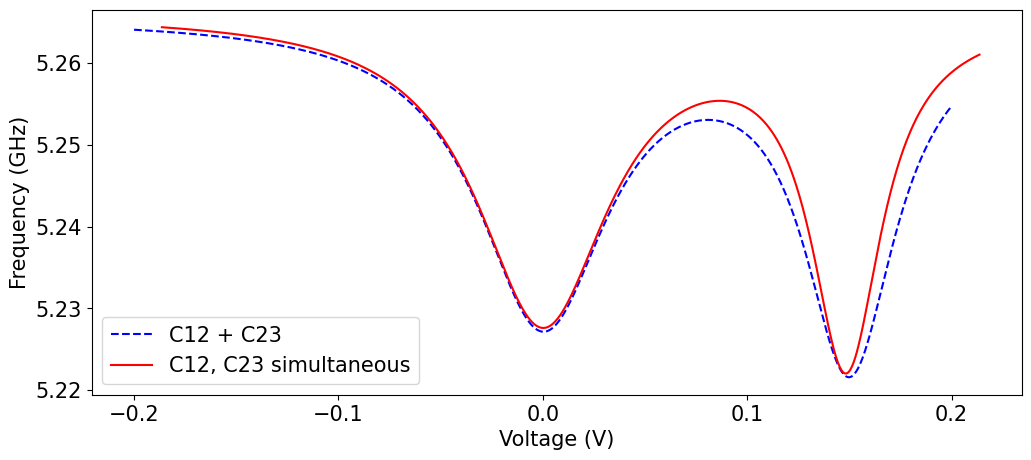

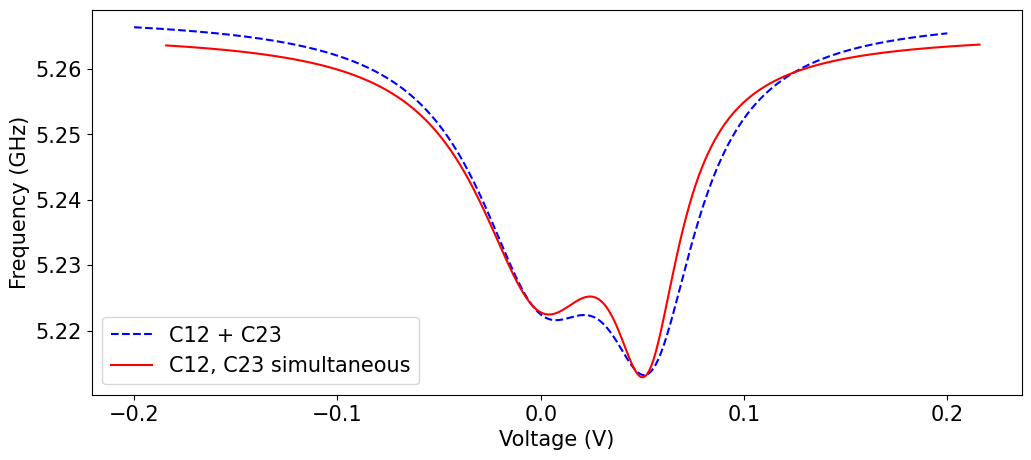

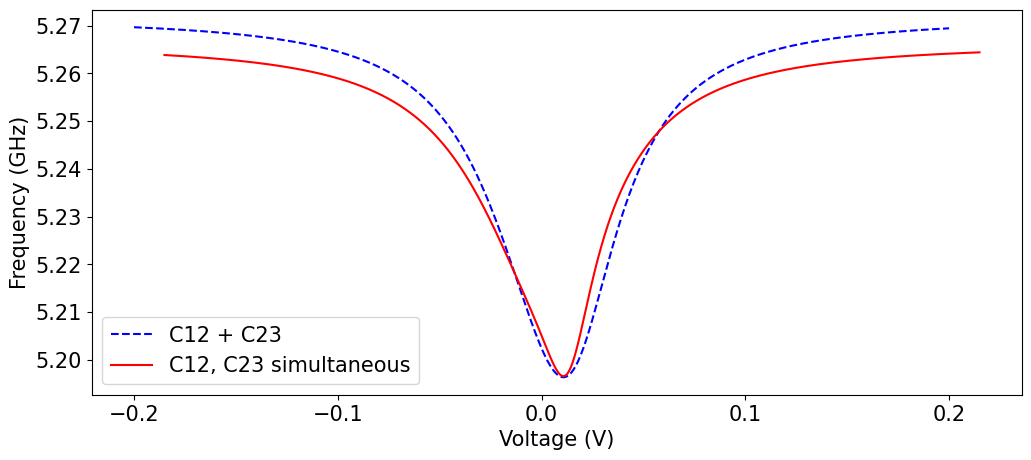

In [472]:
### C12, C23, C12 + C23

coupler_combination = ('C12', 'C23')
for i in range(len(couplers_to_C12_C23_C34_popt[coupler_combination])):
    
    # C12 and C23 individual
    C12_popt = couplers_to_C12_C23_C34_popt[('C12',)][0]
    C23_popt = couplers_to_C12_C23_C34_popt[('C23',)][0]
    
    C12_voltages = couplers_to_C12_C23_C34_voltages[('C12',)][0]
    C23_voltages = couplers_to_C12_C23_C34_voltages[('C23',)][0]
    
    C12_peak_voltage = couplers_to_C12_C23_C34_peak_voltage[('C12',)][0]
    C23_peak_voltage = couplers_to_C12_C23_C34_peak_voltage[('C23',)][0]
    
    C12_popt = couplers_to_C12_C23_C34_popt[('C12',)][0]
    C23_popt = couplers_to_C12_C23_C34_popt[('C23',)][0]
    
    C12_fit_voltages = np.linspace(C12_voltages[0], C12_voltages[-1], 1001)
    C23_fit_voltages = np.linspace(C23_voltages[0], C23_voltages[-1], 1001)
    
    C12_function = couplers_to_C12_C23_C34_function[('C12',)][0]
    C23_function = couplers_to_C12_C23_C34_function[('C23',)][0]
    
#     plt.plot(C12_fit_voltages - C12_peak_voltage, C12_function(C12_fit_voltages), color='magenta', linestyle='dotted', label='C12 individual')
#     plt.plot(C23_fit_voltages - C23_peak_voltage, C23_function(C23_fit_voltages), color='purple', linestyle='dotted', label='C23 individual')
    
    # C12 and C23 sum
    if i == 0:
        x_offset = 0.15
        y_offset = 5.266
    elif i == 1:
        x_offset = 0.054
        y_offset = 5.2635
    elif i == 2:
        x_offset = 0.015
        y_offset = 5.26
#     C12_C23_sum_function = lambda x: C12_function(x + C12_popt[0]) + C12_function(x + C23_popt[0]) - offset
    
    C12_C23_sum_function = lambda x: lorentzian_fit(x - x_offset + C12_popt[0], *C12_popt) + lorentzian_fit(x + C23_popt[0], *C23_popt) - y_offset
    
    sum_voltages = np.linspace(-0.2, 0.2, 1001)
    plt.plot(sum_voltages, C12_C23_sum_function(sum_voltages), color='blue', linestyle='dashed', label='C12 + C23')
    
    
    
    
    C12_C23_popt = couplers_to_C12_C23_C34_popt[coupler_combination][i]
    
    C12_C23_voltages = couplers_to_C12_C23_C34_voltages[coupler_combination][i]
    C12_C23_peak_voltage = couplers_to_C12_C23_C34_peak_voltage[coupler_combination][i]
    
    C12_C23_fit_voltages = np.linspace(C12_C23_voltages[0], C12_C23_voltages[-1], 1001)
    C12_C23_function = couplers_to_C12_C23_C34_function[coupler_combination][i]
    
    plt.plot(C12_C23_fit_voltages - C12_C23_peak_voltage, C12_C23_function(C12_C23_fit_voltages), color='red', label='C12, C23 simultaneous')
    

    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')
    plt.legend()
    
    plt.show()

### 4. Qubit frequency vs coupler flux at different qubit frequencies

In [497]:
Q2_filenames = [generate_filename('0803', '1719'),
               generate_filename('0803', '1802'),
               generate_filename('0803', '2302'),
               generate_filename('0804', '0103'),
               generate_filename('0804', '1249')]

# voltage point to set Q2 at to get the different frequencies
Q2_voltage_points = [ 0.55752395, -1.6788392, -1.41436744,  1.65044077,  1.95304891]



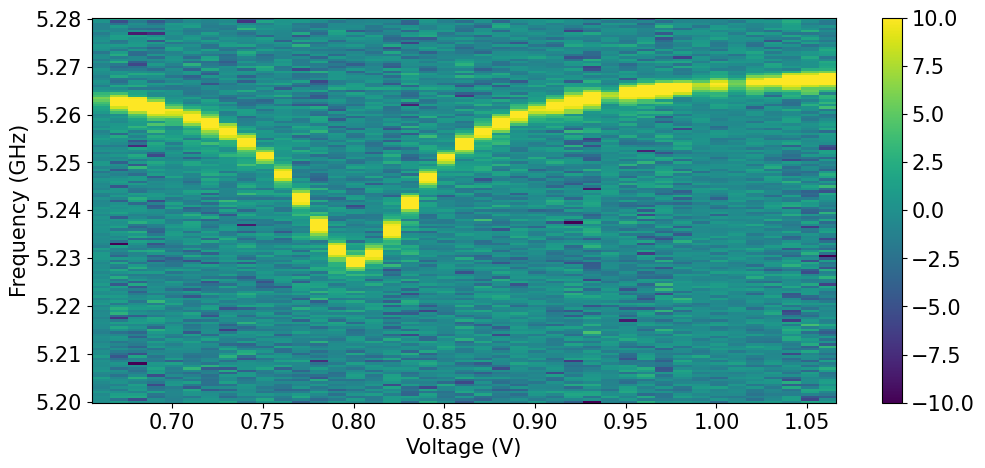

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


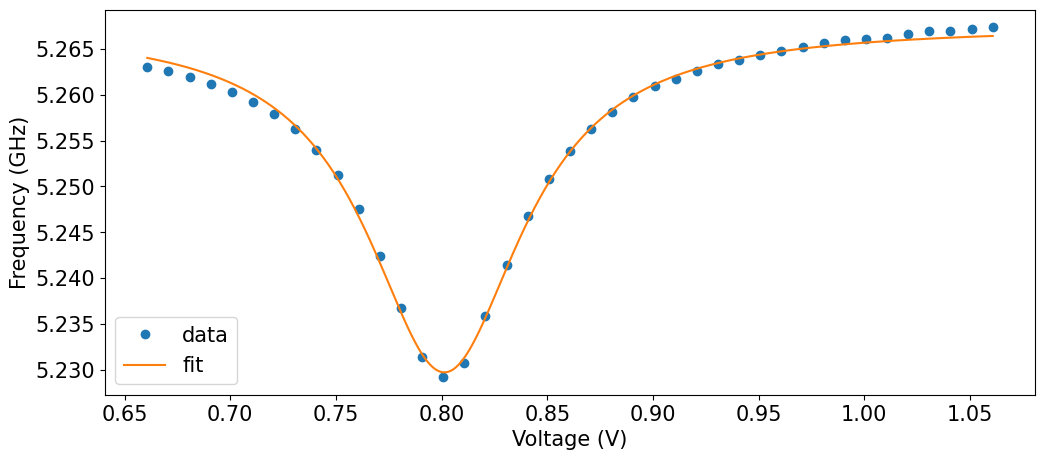

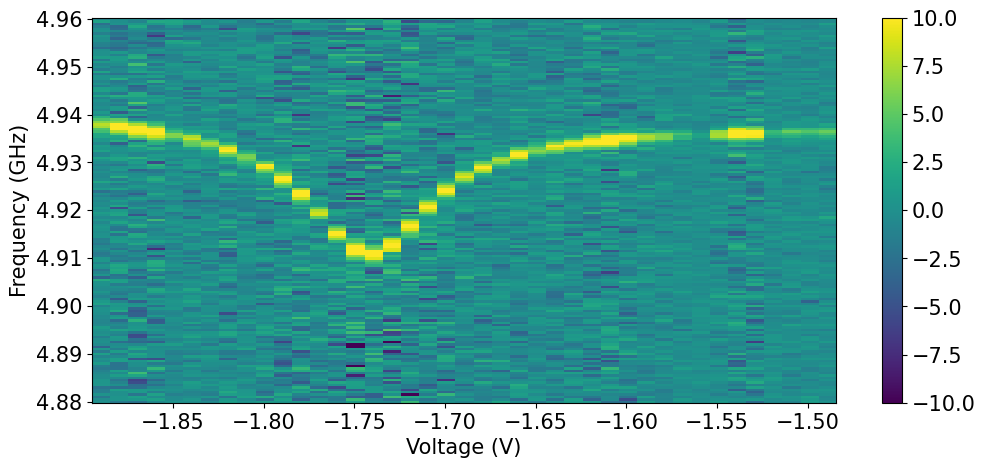

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


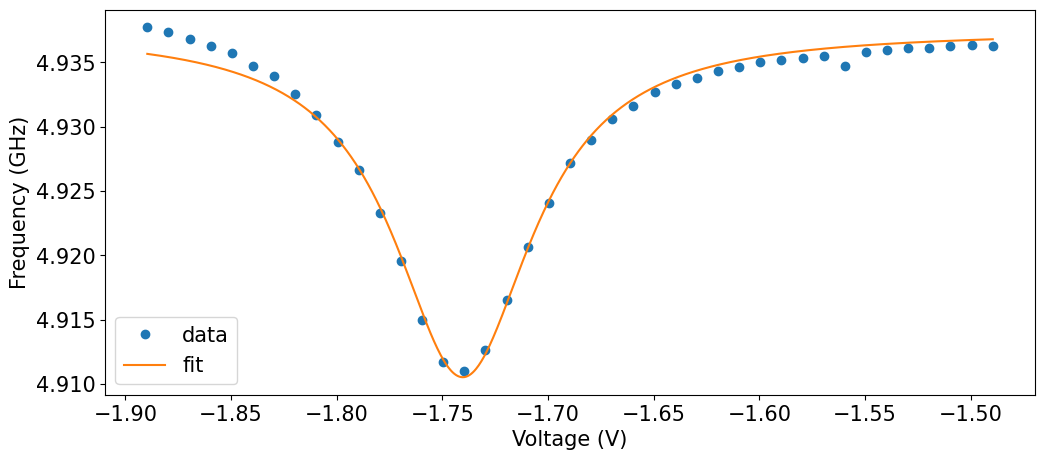

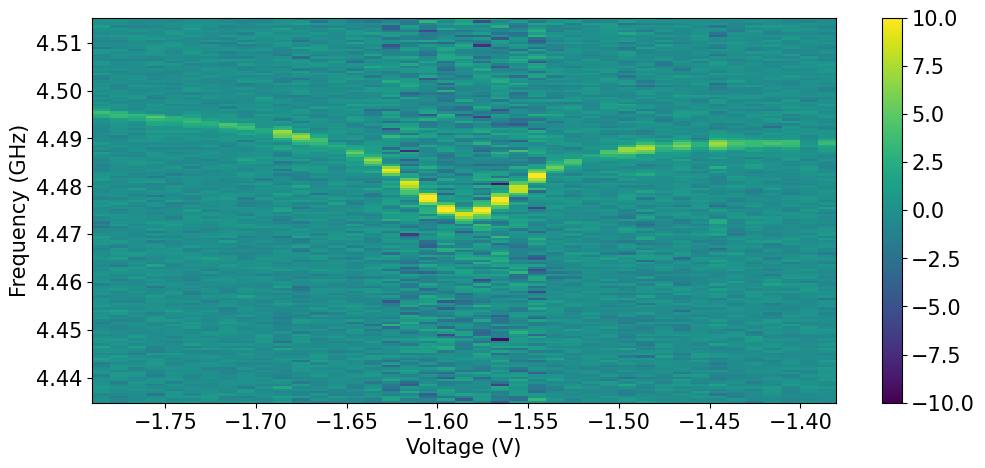

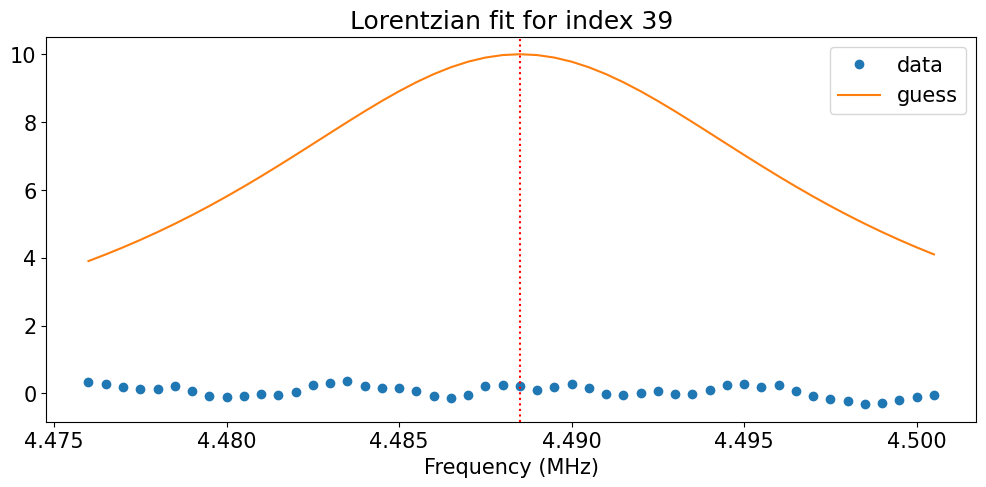

Couldn't get a fit
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


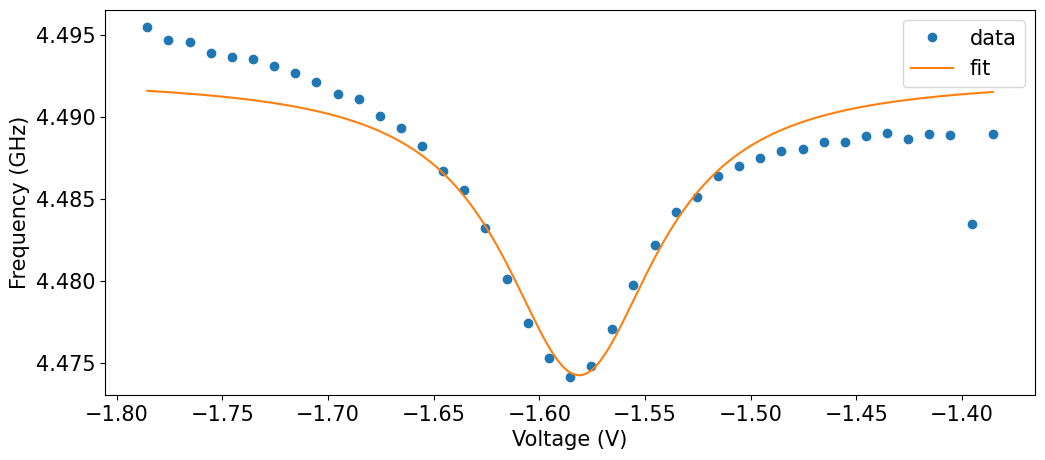

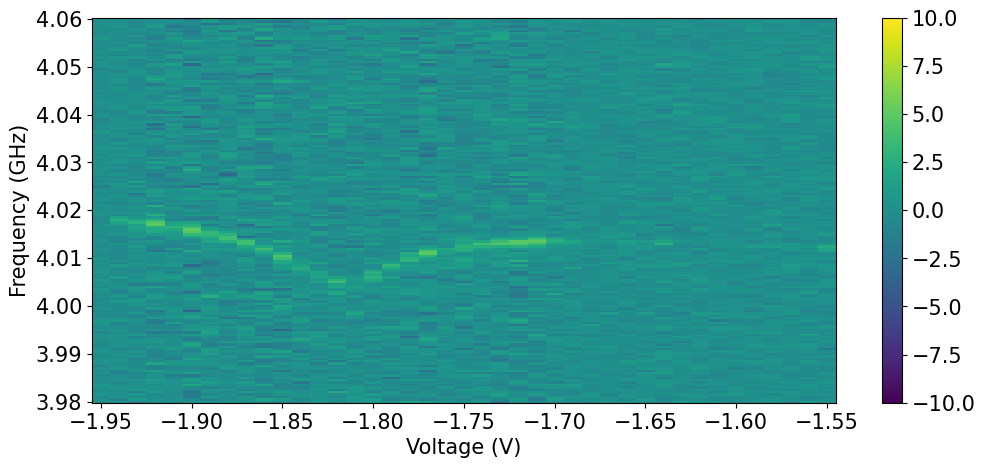

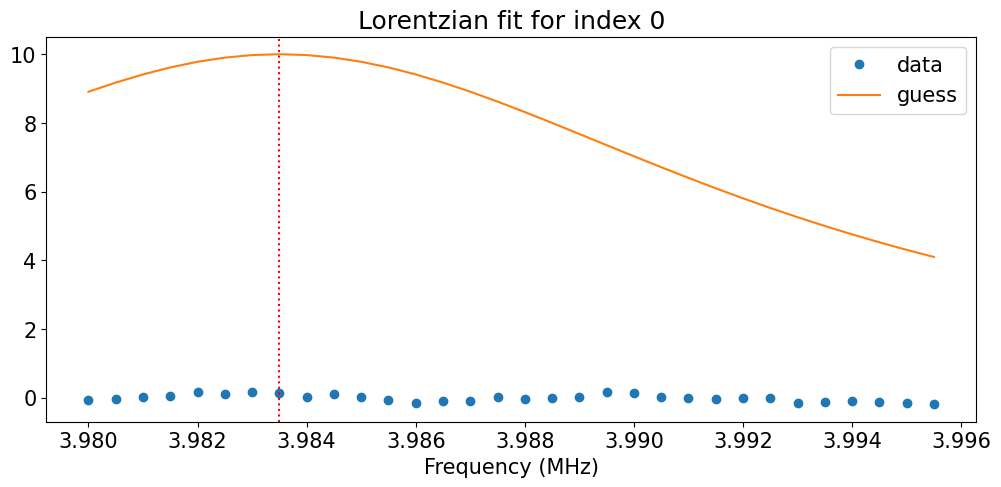

Couldn't get a fit


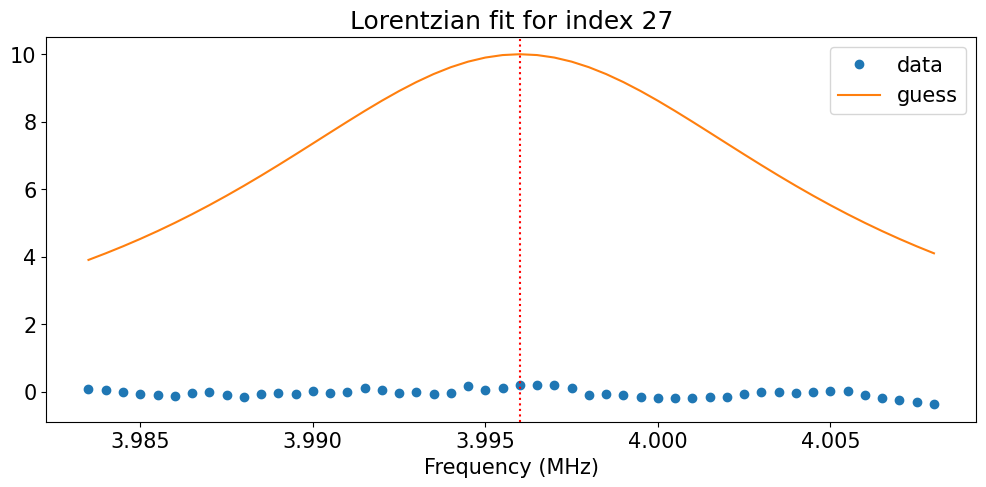

Couldn't get a fit


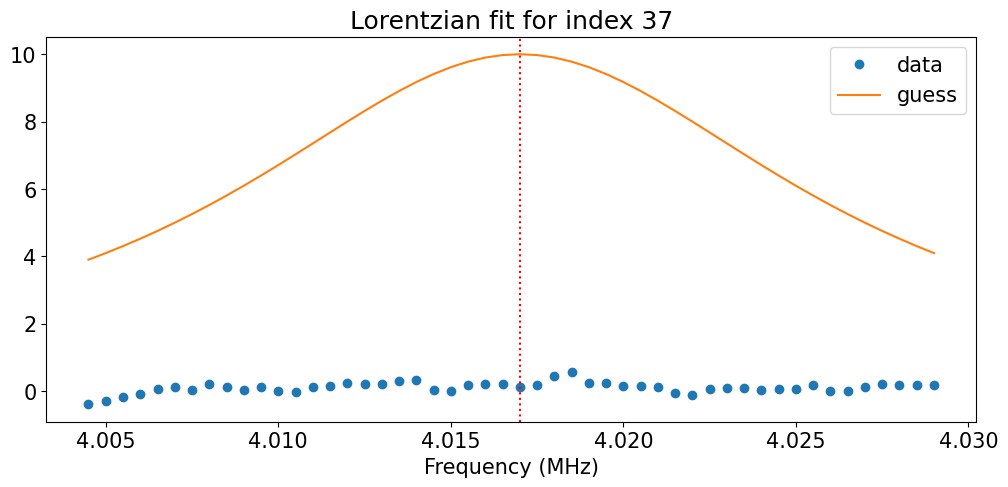

Couldn't get a fit


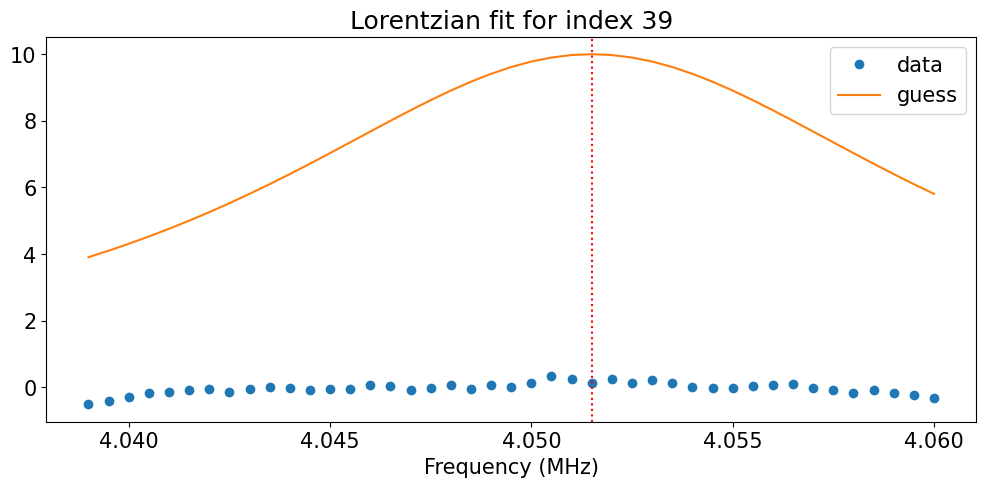

Couldn't get a fit
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


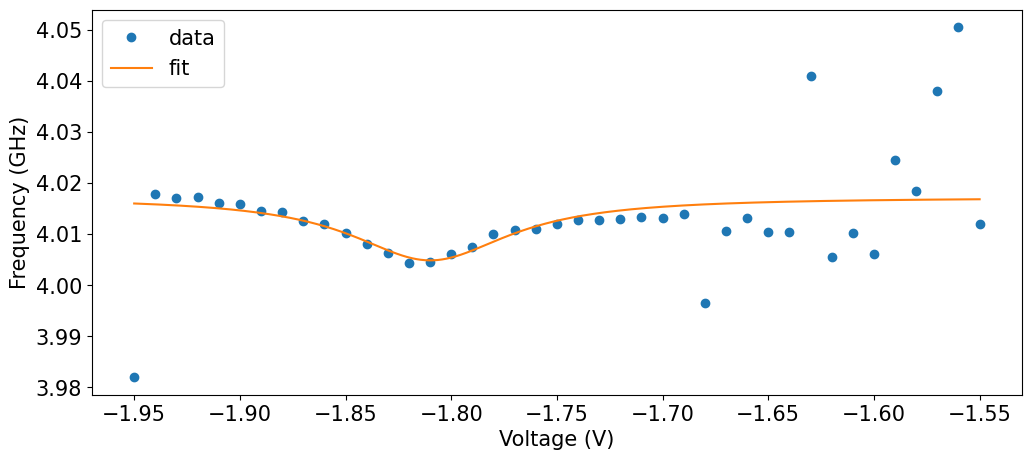

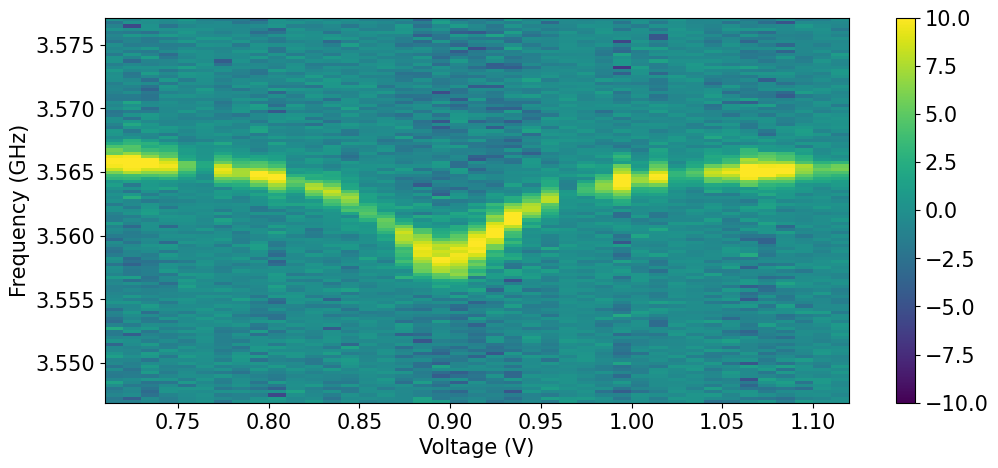

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


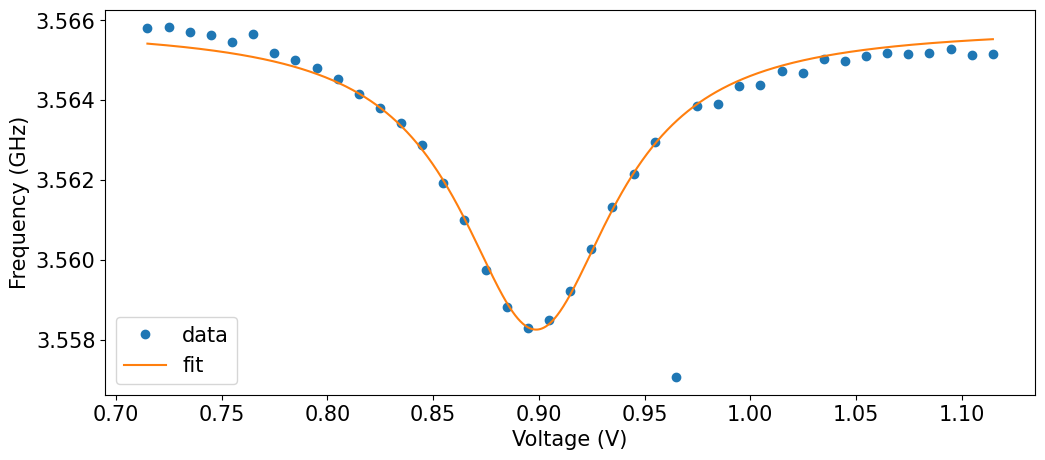

In [510]:
Q2_frequencies_peak = []
Q2_frequencies_flat = []

for i in range(len(Q2_filenames)):
    filename = Q2_filenames[i]

    voltage_vector, frequencies, transmission_data = get_data(filename)
    frequency_step = frequencies[1] - frequencies[0]
    voltage_step = voltage_vector[1] - voltage_vector[0]

    plt.imshow(transmission_data, vmin=-10, vmax=10, aspect='auto', interpolation='None', origin='lower', extent=(voltage_vector[0] - voltage_step/2, voltage_vector[-1] + voltage_step/2, frequencies[0] - frequency_step/2, frequencies[-1] + frequency_step/2))
    # plt.plot(indices_with_fit + 0.5, center_frequencies, marker='o', linestyle='', color='red')

    plt.colorbar()
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.show()

    plot_fits = False
    start_index = 5
    frequency_index_span = 50


#     voltage_data, frequency_data, transmission_data = get_data(filename)
    file_voltages, file_frequencies, error = get_center_frequencies(voltage_vector, frequencies, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)
    plt.show()


    voltages = np.array(file_voltages)
    frequencies = np.array(file_frequencies)
    plt.plot(voltages, frequencies, linestyle='', marker='o', label='data')

    if i == 3:
        start_index = 1
        end_index = -14
    else:
        start_index = 0
        end_index = None

    if i == 4:
        ignore_indices = [25]
    else:
        ignore_indices = []
        
        
    kept_indices = []
    for i in range(len(voltages)):
        if not i in ignore_indices:
            kept_indices.append(i)
    print(kept_indices)
    restricted_voltages = voltages[kept_indices]
    restricted_frequencies = frequencies[kept_indices]
    
    restricted_voltages = restricted_voltages[start_index:end_index]
    restricted_frequencies = restricted_frequencies[start_index:end_index]
    
    popt = fit_coupler_peak(restricted_voltages, restricted_frequencies)
#     plt.plot(restricted_voltages, restricted_frequencies, linestyle='', marker='o', label='data')
    
    coupler_function = lambda x: lorentzian_fit(x, *popt)
    
    fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
    fit_frequencies = coupler_function(fit_voltages)
    
    peak_frequency = coupler_function(popt[0])
    flat_frequency = coupler_function(popt[-1])
    
    Q2_frequencies_peak.append(peak_frequency)
    Q2_frequencies_flat.append(flat_frequency)
    
    plt.plot(fit_voltages, fit_frequencies, label='fit')
    
    plt.legend()
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.show()
    
Q2_frequencies_peak = np.array(Q2_frequencies_peak)
Q2_frequencies_flat = np.array(Q2_frequencies_flat)


In [506]:
Q2_tunable_spec_voltages = [-1.5, -1.465, -1.43, -1.395, -1.36, -1.325, -1.29, -1.255, -1.22, -1.185, -1.15, -1.115, -1.08, -1.045, -1.01, -0.975, -0.94, -0.905, -0.87, -0.835, -0.8, -0.765, -0.73, -0.695, -0.66, -0.625, -0.59, -0.555, -0.52, -0.485, -0.45, -0.415, -0.38, -0.345, -0.31, -0.275, -0.24, -0.205, -0.17, -0.135, -0.1, -0.065, -0.03, 0.005, 0.04, 0.075, 0.11, 0.145, 0.18, 0.215, 0.25, 0.285, 0.32, 0.355, 0.39, 0.425, 0.46, 0.495, 0.53, 0.565, 0.6, 0.635, 0.67, 0.705, 0.74, 0.775, 0.81, 0.845, 0.88, 0.915, 0.95, 0.985, 1.02, 1.055, 1.09, 1.125, 1.16, 1.195, 1.23, 1.265, 1.3, 1.335, 1.37, 1.405, 1.44, 1.475, 1.51, 1.545, 1.58, 1.615, 1.65, 1.685, 1.72, 1.755, 1.79, 1.825, 1.86, 1.895, 1.93, 1.965, 2.0]

Q2_tunable_spec_frequencies = [4.09321, 4.02006, 3.94797, 3.878, 3.8114, 3.74961, 3.69418, 3.64676, 3.60893, 3.58212, 3.56742, 3.56546, 3.57633, 3.59956, 3.63417, 3.67884, 3.73201, 3.79204, 3.85733, 3.92642, 3.99798, 4.07092, 4.14427, 4.21728, 4.28932, 4.35989, 4.42862, 4.4952, 4.5594, 4.62105, 4.68003, 4.73625, 4.78964, 4.84018, 4.88784, 4.93261, 4.9745, 5.01351, 5.04966, 5.08297, 5.11346, 5.14115, 5.16605, 5.1882, 5.20761, 5.22429, 5.23827, 5.24956, 5.25817, 5.26411, 5.26738, 5.26799, 5.26594, 5.26122, 5.25384, 5.24378, 5.23103, 5.21558, 5.19742, 5.17653, 5.15289, 5.12648, 5.09728, 5.06526, 5.03042, 4.99272, 4.95215, 4.9087, 4.86236, 4.81314, 4.76105, 4.70612, 4.64839, 4.58795, 4.5249, 4.45938, 4.39161, 4.32184, 4.25041, 4.17778, 4.1045, 4.03127, 3.95895, 3.88857, 3.82137, 3.75874, 3.70223, 3.65347, 3.61407, 3.58548, 3.56886, 3.56492, 3.57384, 3.59521, 3.62816, 3.67138, 3.72335, 3.78242, 3.84701, 3.9156, 3.98686]

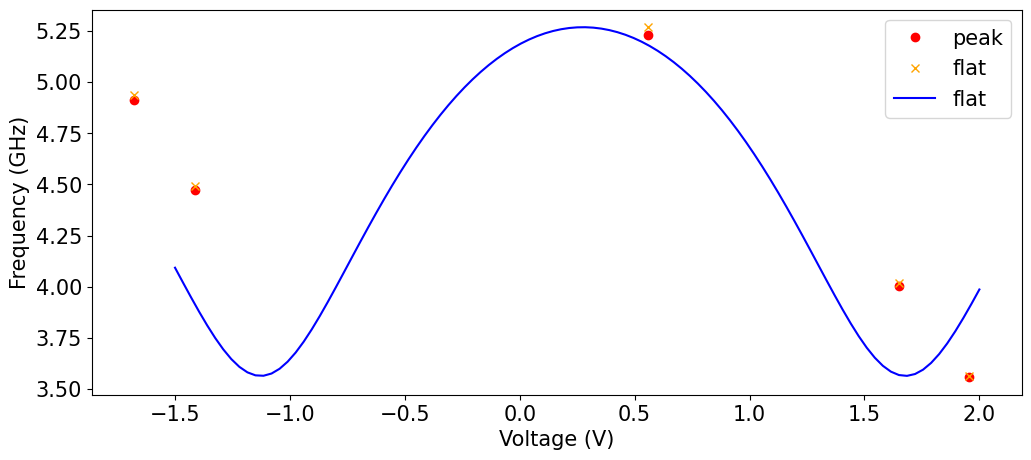

In [507]:
plt.plot(Q2_voltage_points, Q2_frequencies_peak, marker='o', linestyle='', color='red', label='peak')
plt.plot(Q2_voltage_points, Q2_frequencies_flat, marker='x', linestyle='', color='orange', label='flat')

plt.plot(Q2_tunable_spec_voltages, Q2_tunable_spec_frequencies, color='blue', label='flat')

plt.legend()

plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')

plt.show()

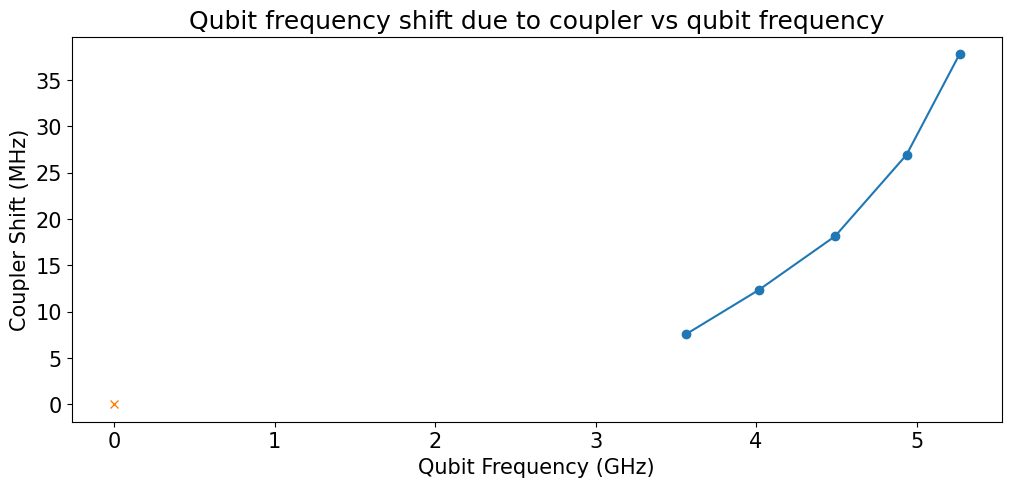

In [520]:
total_shift = np.abs(Q2_frequencies_peak - Q2_frequencies_flat)*1e3 # MHz

plt.plot(Q2_frequencies_flat, total_shift, marker='o')
plt.plot(0, 0, marker='x')


plt.xlabel('Qubit Frequency (GHz)')
plt.ylabel('Coupler Shift (MHz)')

plt.title('Qubit frequency shift due to coupler vs qubit frequency')

plt.show()